In [108]:
!pip install pandas openpyxl

Defaulting to user installation because normal site-packages is not writeable


In [109]:
import pandas as pd
import os
import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

# === Configuration ===
file_path = "_CR HDJ 13.xlsx"
skip_rows = 5  #actual data seems to start from row 6 (0-indexed row 5)
check_interval_seconds = 30  # How often to check for updates

In [110]:
# === Function to Read and Clean Excel File ===
def read_excel_file(path):
    try:
        # Read the Excel file, skipping metadata/header rows
        df = pd.read_excel(path, skiprows=skip_rows)
        
        # Set first column as index (if desired, optional)
        if df.columns[0] != 'Unnamed: 0':
            df.set_index(df.columns[0], inplace=True)

        # Clean column names
        df.columns = [str(col).strip() for col in df.columns]

        # Print a preview
        print(f"\n[INFO] Data loaded - {df.shape[0]} rows, {df.shape[1]} columns")
        print(df.head(3))
        return df

    except Exception as e:
        print(f"[ERROR] Could not read file: {e}")
        return None

# === Main Monitoring Loop ===
def monitor_file(path):
    print(f"Monitoring file: {path}")
    last_modified = None

    while True:
        if os.path.exists(path):
            modified_time = os.path.getmtime(path)

            if last_modified is None or modified_time != last_modified:
                print(f"\n[INFO] Detected file change or first load...")
                df = read_excel_file(path)
                last_modified = modified_time

        else:
            print(f"[WARNING] File not found: {path}")

        time.sleep(check_interval_seconds)


### Ages :

Ages: [64.0, 64.0, 67.0, 51.0, 53.0, 21.0, 69.0, 75.0, 55.0, 56.0, 55.0, 46.0, 68.0, 67.0, 55.0, 66.0, 41.0, 52.0, 76.0, 27.0]
Average Age: 56.40
Standard Deviation: 14.12


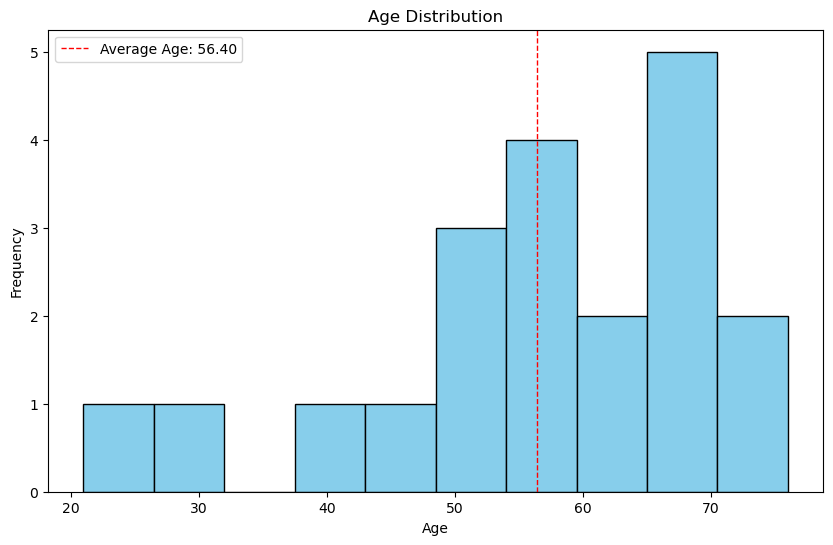

In [112]:
# Load the Excel file (no header)
df = pd.read_excel(file_path, header=None)

# Get the 7th row (index 6)
birthdates_row = df.iloc[6, :]

# Define today's date
from datetime import datetime
today = datetime.today()

# Function to calculate age
def calculate_age(birth_str):
    try:
        birth_date = pd.to_datetime(birth_str, dayfirst=True, errors='coerce')
        if pd.isnull(birth_date):
            return np.nan
        age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
        return age
    except:
        return np.nan

# Apply the function and drop NaNs
ages = birthdates_row.apply(calculate_age).dropna()

# Calculate statistics
average_age = np.mean(ages)
std_age = np.std(ages)

print("Ages:", ages.tolist())
print(f"Average Age: {average_age:.2f}")
print(f"Standard Deviation: {std_age:.2f}")

# === Visualization ===
plt.figure(figsize=(10, 6))
plt.hist(ages, bins=10, color='skyblue', edgecolor='black')
plt.axvline(average_age, color='red', linestyle='dashed', linewidth=1, label=f'Average Age: {average_age:.2f}')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Genre :

Found 'Genre H/F/I' at row 7
Filtered gender counts: {'Female': 11, 'Male': 9}


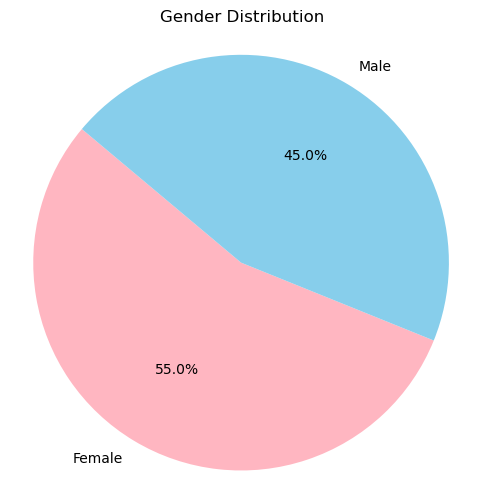

In [113]:
# Load Excel file
df = pd.read_excel(file_path, header=None)

# Step 1: Find the row where 'Genre H/F/I' appears in column 0 (first column)
target = "Genre H/F/I"
match_row = df[df[0].astype(str).str.strip().str.lower() == target.lower()]

if not match_row.empty:
    row_idx = match_row.index[0]
    print(f"Found 'Genre H/F/I' at row {row_idx}")

    # Step 2: Extract gender values from that row, from column 1 onward
    gender_row = df.iloc[row_idx, 1:].dropna().astype(str).str.strip()

    # Step 3: Count occurrences
    label_map = {'H': 'Male', 'F': 'Female', 'I': 'Unknown'}
    counts = gender_row.value_counts()
    filtered_counts = counts[counts.index.isin(label_map.keys())]
    filtered_counts.index = filtered_counts.index.map(label_map)

    print("Filtered gender counts:", filtered_counts.to_dict())

    # Step 4: Plot
    if not filtered_counts.empty:
        colors = ['lightpink','skyblue', 'lightgray']
        plt.figure(figsize=(6, 6))
        plt.pie(filtered_counts, labels=filtered_counts.index, autopct='%1.1f%%',
                colors=colors, startangle=140)
        plt.title('Gender Distribution')
        plt.axis('equal')
        plt.show()
    else:
        print("No valid gender entries (H, F, I) found to plot.")
else:
    print("'Genre H/F/I' not found in column 0.")


### Descriptive statistics by diabetes type:

In [114]:
# Load Excel file
df = pd.read_excel(file_path, header=None)

# --- Step 1: Find the row for "Age du diabète (années)"
label1 = "Age du diabète (années)"
row1 = df[df[0].astype(str).str.strip().str.lower() == label1.lower()]
if row1.empty:
    raise ValueError(f"Label '{label1}' not found.")
idx_age = row1.index[0]

# --- Step 2: Get the next row for "Type de diabète 1/2/AT"
label2 = "Type de diabète 1/2/AT"
if not df.iloc[idx_age + 1, 0].strip().lower() == label2.lower():
    raise ValueError(f"Expected '{label2}' at row {idx_age + 1}. Found: {df.iloc[idx_age + 1, 0]}")
idx_type = idx_age + 1

# --- Step 3: Read the values (skip column 0 which is just the label)
age_values = df.iloc[idx_age, 1:].astype(str).str.strip()
type_values = df.iloc[idx_type, 1:].astype(str).str.strip()

# --- Step 4: Filter out "NON DIAB" and align with diabetes types
valid_mask = age_values.str.upper() != "NON DIAB"
age_numeric = pd.to_numeric(age_values[valid_mask], errors='coerce')
diabetes_types = type_values[valid_mask]

# Create DataFrame of valid data
data = pd.DataFrame({
    "AgeOnset": age_numeric,
    "Type": diabetes_types
}).dropna()

# Map type codes for clarity
type_map = {'1': 'Type 1', '2': 'Type 2', 'AT': 'Atypical'}
data = data[data['Type'].isin(type_map.keys())]
data['Type'] = data['Type'].map(type_map)

# --- Step 5: Generate descriptive stats
grouped = data.groupby("Type")["AgeOnset"].agg(['count', 'mean', 'std', 'min', 'max']).round(2)

# Print results
print("Descriptive statistics by diabetes type:")
print(grouped)


Descriptive statistics by diabetes type:
        count   mean   std   min   max
Type                                  
Type 1      7  28.29  8.85  17.0  40.0
Type 2     11  15.36  8.45   1.0  26.0


This table summarizes the age of diabetes onset for two different types of diabetes (Type 1 and Type 2). Each row represents a diabetes type, and each column shows a statistical measure based on the patients in that group.

#### Type 1 Diabetes:
- 7 patients with valid age data.

- The average age of onset is 28.29 years.

- The spread (standard deviation) is 8.85, which means ages vary quite a bit.

- The youngest onset was 17 years, and the oldest was 40 years.

#### Type 2 Diabetes :
- 11 patients with valid data.

- The average age of onset is 15.36 years, which is unusually young for Type 2 — possibly due to pediatric or early-onset cases.

- The standard deviation is 8.45, still showing a wide range.

- The youngest onset was just 1 year, and the oldest was 26 years.

⚠️ Note: Type 2 diabetes typically occurs later in life. So the very young ages here (like 1 year) might reflect misclassification, special cases (e.g., MODY), or data entry errors — it might be worth double-checking those.

### BMI :

In [13]:
# --- Step 1: Locate BMI row
bmi_label = "BMI (poids[kg] / taille[m]2)"
bmi_row = df[df[0].astype(str).str.strip().str.lower() == bmi_label.lower()]

if bmi_row.empty:
    raise ValueError(f"Label '{bmi_label}' not found.")
bmi_idx = bmi_row.index[0]

# --- Step 2: Get values (skip label column)
bmi_values = df.iloc[bmi_idx, 1:].astype(str).str.strip()

# --- Step 3: Convert to numeric and drop non-numeric/NaN
bmi_numeric = pd.to_numeric(bmi_values, errors='coerce').dropna()

# --- Step 4: Descriptive statistics
stats = bmi_numeric.describe().round(2)

print("📊 Descriptive statistics for BMI:")
print(stats)


📊 Descriptive statistics for BMI:
count    17.00
mean     26.21
std       5.19
min      18.13
25%      22.21
50%      25.64
75%      30.43
max      35.00
Name: 19, dtype: float64


- The mean BMI (26.21) falls in the overweight category (25–29.9).

- The median (25.64) being slightly lower than the mean suggests the data is slightly right-skewed — a few higher BMIs raise the average.

- The range goes from 18.13 (normal weight) to 35.00 (obese).

- The IQR (Interquartile Range) is 30.43 - 22.21 = 8.22, showing moderate variability in BMI values.

### Hba1c and Insulin :

In [14]:
# --- Step 1: Locate Hba1c row
label_hba1c = "Hba1c"
row_hba1c = df[df[0].astype(str).str.strip().str.lower() == label_hba1c.lower()]
if row_hba1c.empty:
    raise ValueError(f"Label '{label_hba1c}' not found.")
idx_hba1c = row_hba1c.index[0]
hba1c_vals = df.iloc[idx_hba1c, 1:].astype(str).str.strip()

# --- Step 2: Locate Insulin use row
label_insulin = "Insuline (Y/N)"
row_insulin = df[df[0].astype(str).str.strip().str.lower() == label_insulin.lower()]
if row_insulin.empty:
    raise ValueError(f"Label '{label_insulin}' not found.")
idx_insulin = row_insulin.index[0]
insulin_vals = df.iloc[idx_insulin, 1:].astype(str).str.strip().str.upper()

# --- Step 3: Create DataFrame and clean
data = pd.DataFrame({
    "Hba1c": pd.to_numeric(hba1c_vals, errors='coerce'),
    "Insulin": insulin_vals
}).dropna()

# Filter insulin responses to valid Y/N only
data = data[data["Insulin"].isin(["Y", "N"])]

# --- Step 4: Group and describe
grouped = data.groupby("Insulin")["Hba1c"].agg(['count', 'mean', 'std', 'min', 'median', 'max']).round(2)

# Rename index for clarity
grouped.index = grouped.index.map({'Y': 'Yes (Insulin)', 'N': 'No Insulin'})

print("📊 Hba1c Descriptive Stats by Insulin Usage:")
print(grouped)


📊 Hba1c Descriptive Stats by Insulin Usage:
               count  mean   std  min  median   max
Insulin                                            
No Insulin         4  7.38  1.44  6.3    6.85   9.5
Yes (Insulin)     13  7.90  1.23  6.2    7.80  10.4


This table compares HbA1c levels (a measure of long-term blood sugar control) between two groups:

- People not using insulin

- People using insulin

##### No Insulin (n = 4):
- Average HbA1c: 7.38%, which is slightly above the recommended target (usually <7%).

- Median is slightly lower (6.85%), meaning more than half are closer to target.

- Range: from 6.3% to 9.5% — some individuals still have high HbA1c.

##### Yes (Insulin) (n = 13):
- Average HbA1c: 7.90% — a bit higher than the no-insulin group.

- Median: 7.80% — very close to the mean, indicating symmetric distribution.

- Range: 6.2% to 10.4% — includes patients with relatively good control and others with quite poor control.

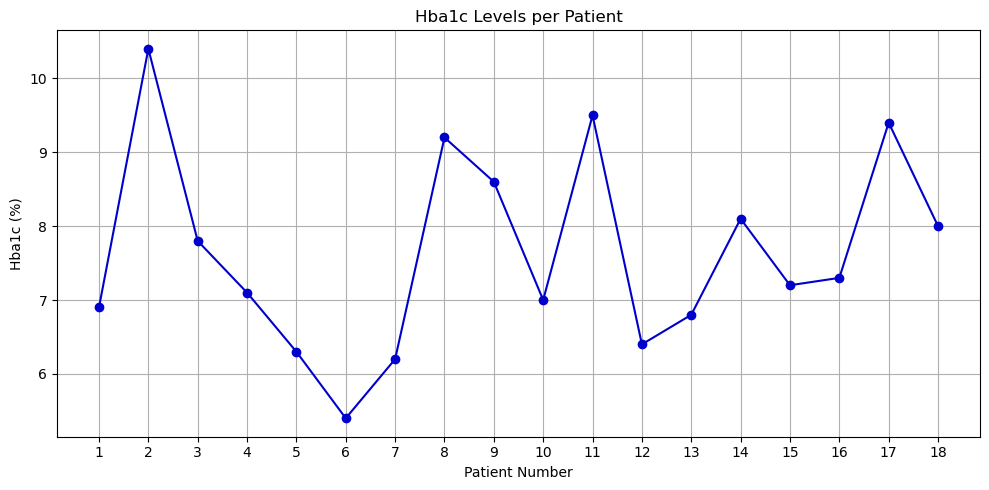

In [15]:
# --- Step 1: Locate Hba1c row
label_hba1c = "Hba1c"
row_hba1c = df[df[0].astype(str).str.strip().str.lower() == label_hba1c.lower()]
if row_hba1c.empty:
    raise ValueError(f"Label '{label_hba1c}' not found.")
idx_hba1c = row_hba1c.index[0]

# --- Step 2: Extract numeric Hba1c values
hba1c_vals = pd.to_numeric(df.iloc[idx_hba1c, 1:], errors='coerce').dropna().reset_index(drop=True)

# --- Step 3: Set patient numbers as 1 to N
patient_numbers = range(1, len(hba1c_vals) + 1)

# --- Step 4: Plot
plt.figure(figsize=(10, 5))
plt.plot(patient_numbers, hba1c_vals, marker='o', linestyle='-', color='mediumblue')

# Labels and styling
plt.xlabel("Patient Number")
plt.ylabel("Hba1c (%)")
plt.title("Hba1c Levels per Patient")
plt.grid(True)
plt.xticks(patient_numbers)  # Optional: show every patient number
plt.tight_layout()
plt.show()


- HbA1c levels vary across patients, with some showing higher values (e.g., Patient 2 at ~10%, Patient 11 at ~10%) and others lower (e.g., Patient 5 at ~6%).
- There is no consistent trend; levels fluctuate, indicating individual differences in blood sugar control.
- Patients 2, 11, and 17 have the highest levels (~9-10%), while Patients 5 and 6 have the lowest (~6%).

### Grade de risque IWGDF :
(International Working Group on the Diabetic Foot) 

🚦 What is the “IWGDF Risk Grade”?
It’s a grading system used to assess a diabetic patient’s risk of developing a foot ulcer based on certain risk factors, such as:
- Peripheral neuropathy
- Foot deformities
- Previous foot ulcers
- Poor glycemic control
- Vascular disease
- The IWGDF Risk Grade helps healthcare providers determine the level of care and monitoring needed to prevent foot complications in diabetic patients.

In [16]:
grade_meaning = {
    0: "Low risk — Normal sensation, no PAD, no deformity",
    1: "Moderate risk — Neuropathy or PAD, but no deformity or ulcer history",
    2: "High risk — Neuropathy plus PAD or deformity",
    3: "Very high risk — Previous foot ulcer or amputation"
}
grade = pd.DataFrame.from_dict(grade_meaning, orient='index', columns=['Meaning'])
grade.index.name = 'Grade'
display(grade)

,Meaning
Grade,
0,"Low risk — Normal sensation, no PAD, no deformity"
1,"Moderate risk — Neuropathy or PAD, but no defo..."
2,High risk — Neuropathy plus PAD or deformity
3,Very high risk — Previous foot ulcer or amputa...


IWGDF Grade: Ranges from 0 (low risk) to 3 (very high risk), with a mean of ~1.2.
Patients 6, 7, 8, 9, 10, 12, 15 show higher risk (grade 3).


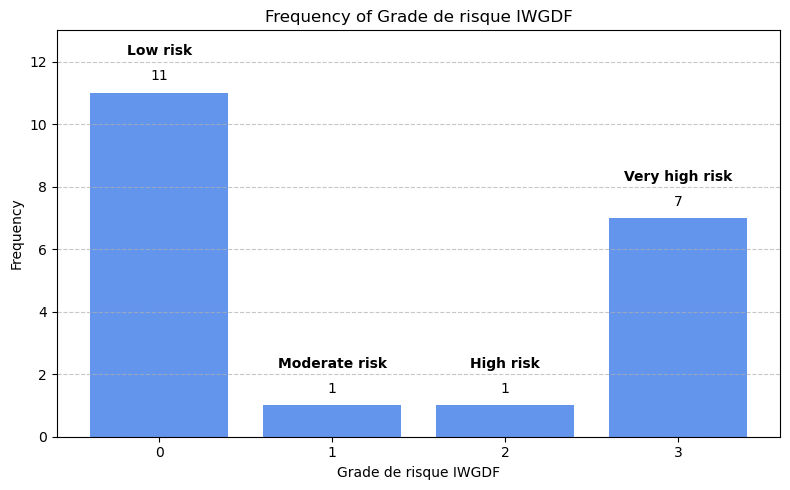

In [17]:
# Load Excel file
file_path = "_CR HDJ 13.xlsx"
df = pd.read_excel(file_path, header=None)

label_risk = "Grade de risque IWGDF"
row_risk = df[df[0].astype(str).str.strip().str.lower() == label_risk.lower()]
if row_risk.empty:
    raise ValueError(f"Label '{label_risk}' not found.")
idx_risk = row_risk.index[0]

risk_values = pd.to_numeric(df.iloc[idx_risk, 1:], errors='coerce').dropna().astype(int)

min_iwgdf = risk_values.min()
max_iwgdf = risk_values.max()
mean_iwgdf = risk_values.mean()

high_risk_patients = risk_values[risk_values == 3].index + 1

print(f"IWGDF Grade: Ranges from {min_iwgdf} (low risk) to {max_iwgdf} (very high risk), with a mean of ~{mean_iwgdf:.1f}.")
print(f"Patients {', '.join(map(str, high_risk_patients.tolist()))} show higher risk (grade 3).")

all_grades = pd.Series(index=[0,1,2,3], data=0)
freq = all_grades.add(risk_values.value_counts(), fill_value=0).astype(int).sort_index()

risk_labels = {
    0: "Low risk",
    1: "Moderate risk",
    2: "High risk",
    3: "Very high risk"
}

plt.figure(figsize=(8,5))
bars = plt.bar(freq.index, freq.values, color='cornflowerblue')

for bar in bars:
    grade = int(bar.get_x() + 0.5)
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, f'{int(height)}', ha='center', va='bottom')
    plt.text(bar.get_x() + bar.get_width()/2, height + 1.1, risk_labels.get(grade, ""), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel("Grade de risque IWGDF")
plt.ylabel("Frequency")
plt.title("Frequency of Grade de risque IWGDF")
plt.xticks(freq.index, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 13)  # <-- Set y-axis limit here
plt.tight_layout()
plt.show()


The mean IWGDF grade is approximately 1.2, suggesting that, on average, the patients fall between low and moderate risk.


⚠️  However, specific patients (6, 7, 8, 9, 10, 12, and 15) are identified as having a higher risk, all classified under Grade 3, indicating they have a very high risk due to previous foot ulcers or amputations. This highlights a subset of patients requiring more intensive care.

## Pressure values:

| Term                                                        | What it measures                                      | Normal Range   | Limb          |
| ----------------------------------------------------------- | ----------------------------------------------------- | -------------- | ------------- |
| MESI Pression gros orteil D norme 80-120 mmHg               | Absolute systolic pressure (mmHg) at right big toe    | 80-120 mmHg    | Right big toe |
| MESI Pression gros orteil G norme 80-120 mmHg               | Absolute systolic pressure (mmHg) at left big toe     | 80-120 mmHg    | Left big toe  |
| MESI Indice de Pression Systolique Gros Orteil D norme>0.70 | Toe-brachial systolic pressure ratio at right big toe | >0.70 (normal) | Right big toe |
| MESI Indice de Pression Systolique Gros Orteil G norme>0.70 | Toe-brachial systolic pressure ratio at left big toe  | >0.70 (normal) | Left big toe  |


In [115]:
def get_numeric_row(df, label):
    # Find the row with matching label (case-insensitive, stripped)
    row = df[df[0].astype(str).str.strip().str.lower() == label.lower()]
    if row.empty:
        raise ValueError(f"Label '{label}' not found.")
    idx = row.index[0]
    # Convert to numeric, coercing errors, drop NaN
    numeric_vals = pd.to_numeric(df.iloc[idx, 1:], errors='coerce')
    return numeric_vals

                                               Label        Mean        Std  \
0      MESI Pression gros orteil D norme 80-120 mmHg  124.761741  40.712592   
1      MESI Pression gros orteil G norme 80-120 mmHg  132.861605  39.627074   
2  MESI Indice de Pression Systolique Gros Orteil...    0.986327   0.296554   
3  MESI Indice de Pression Systolique Gros Orteil...    1.047719   0.290981   

         Min     Max  
0  35.473562  182.00  
1  29.693304  188.00  
2   0.234803    1.45  
3   0.175784    1.32  


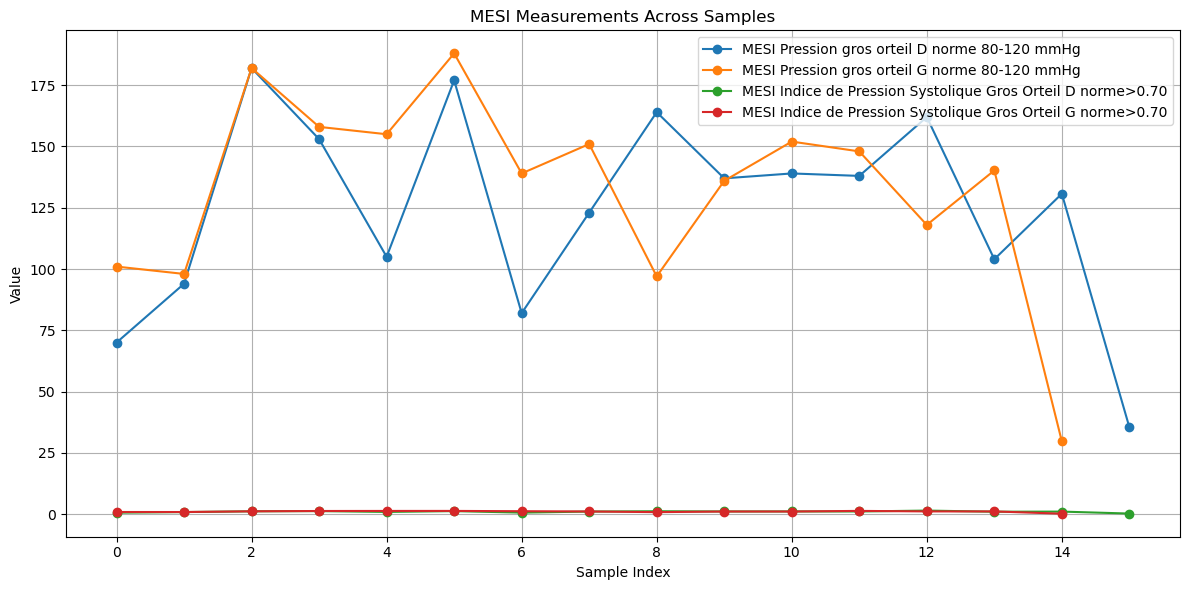

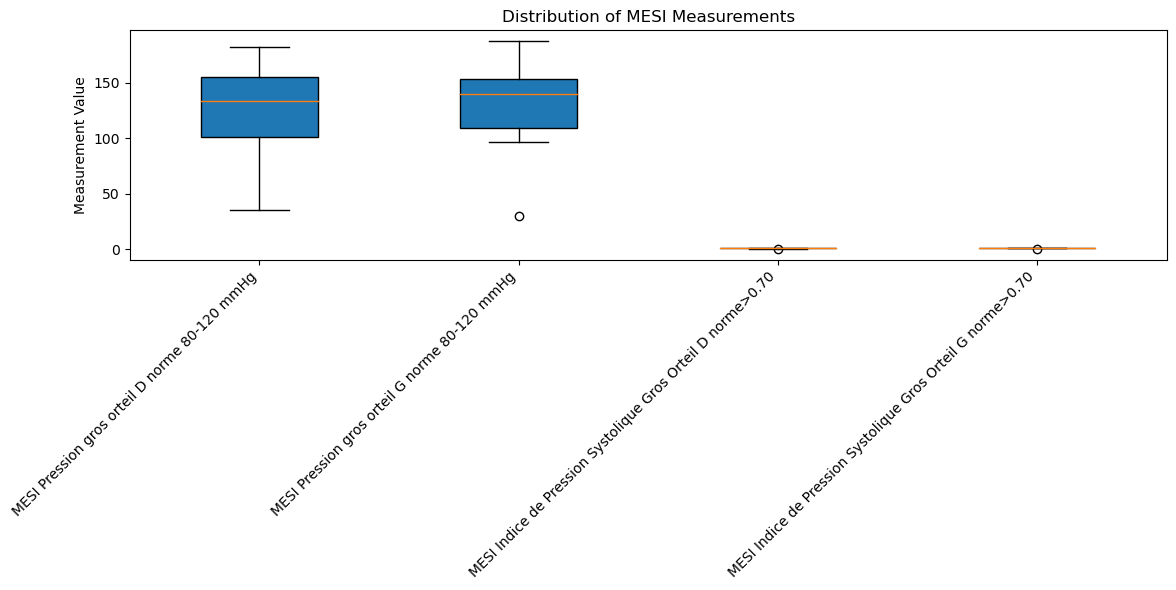

In [116]:
labels_to_plot = [
    "MESI Pression gros orteil D norme 80-120 mmHg",
    "MESI Pression gros orteil G norme 80-120 mmHg",
    "MESI Indice de Pression Systolique Gros Orteil D norme>0.70",
    "MESI Indice de Pression Systolique Gros Orteil G norme>0.70",
]

data_dict = {}
summary_stats = []

for label in labels_to_plot:
    try:
        data = get_numeric_row(df, label).dropna()
        data_dict[label] = data.values

        summary_stats.append({
            "Label": label,
            "Mean": data.mean(),
            "Std": data.std(),
            "Min": data.min(),
            "Max": data.max()
        })
    except Exception as e:
        print(f"Error retrieving '{label}': {e}")

# Convert to DataFrame for stats
summary_df = pd.DataFrame(summary_stats)
print(summary_df)

# Plot line plot
plt.figure(figsize=(12, 6))
for label, values in data_dict.items():
    plt.plot(range(len(values)), values, marker='o', label=label)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('MESI Measurements Across Samples')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot boxplot
plt.figure(figsize=(12,6))
plt.boxplot([vals for vals in data_dict.values()], labels=data_dict.keys(), patch_artist=True)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Measurement Value')
plt.title('Distribution of MESI Measurements')
plt.tight_layout()
plt.show()

Line plot: shows how values for each MESI label change across samples (columns in your dataframe).

Boxplot: shows the spread, median, quartiles, and outliers of values for each MESI label, great for spotting differences in distribution.

There is significant variability in both toe pressures and TBI values(Toe-Brachial Index).

###### TBI  : It’s a non-invasive diagnostic ratio used to assess blood flow to the feet, especially useful when ABI (Ankle-Brachial Index) is unreliable (e.g., in diabetic patients with calcified arteries).

Minimum values for all indicators (especially pressures below 40 mmHg and TBIs < 0.4) could indicate poor peripheral perfusion or severe PAD in some patients.

Despite averages being within normal range, the spread (Std Dev) shows some patients are at serious risk.

#### 🧮 How is TBI Calculated?

$$\
\text{TBI} = \frac{\text{Toe systolic blood pressure}}{\text{Brachial (arm) systolic blood pressure}}
$$

---

#### 🧭 Normal and Abnormal Ranges

| **TBI Value** | **Interpretation**                                      |
|---------------|----------------------------------------------------------|
| > 0.70        | ✅ Normal – Good perfusion                               |
| 0.64 – 0.70   | ⚠️ Borderline                                            |
| < 0.64        | ❌ Abnormal – Indicates possible PAD                     |
| < 0.30        | 🚨 Critical ischemia – Very poor blood flow              |

---

#### 🩺 Why is TBI Important?

- In patients with **diabetes** or **kidney disease**, arteries are often **calcified**, which can make **ABI falsely high**.
- **Toe arteries are less likely to calcify**, so **TBI is a more reliable measure** of perfusion in such patients.
- A **low TBI** suggests increased risk of:
  -  Poor wound healing  
  -  Ulceration  
  -  Amputation


## Correlation between grade de risque IWGDF and row 36 to row 39 (pressure values):

In [27]:
labels_to_correlate = [
    "MESI Pression gros orteil D norme 80-120 mmHg",
    "MESI Pression gros orteil G norme 80-120 mmHg",
    "MESI Indice de Pression Systolique Gros Orteil D norme>0.70",
    "MESI Indice de Pression Systolique Gros Orteil G norme>0.70",
]

reference_label = "Grade de risque IWGDF"
reference_data = get_numeric_row(df, reference_label)

correlations = {}

for label in labels_to_correlate:
    try:
        row_data = get_numeric_row(df, label)
        combined = pd.concat([row_data, reference_data], axis=1, keys=[label, reference_label])
        combined = combined.dropna()
        corr = combined[label].corr(combined[reference_label])
        correlations[label] = corr
        print(f"Correlation between '{label}' and '{reference_label}': {corr:.3f}")
    except Exception as e:
        print(f"Error with label '{label}': {e}")


Correlation between 'MESI Pression gros orteil D norme 80-120 mmHg' and 'Grade de risque IWGDF': -0.574
Correlation between 'MESI Pression gros orteil G norme 80-120 mmHg' and 'Grade de risque IWGDF': -0.120
Correlation between 'MESI Indice de Pression Systolique Gros Orteil D norme>0.70' and 'Grade de risque IWGDF': -0.580
Correlation between 'MESI Indice de Pression Systolique Gros Orteil G norme>0.70' and 'Grade de risque IWGDF': 0.074


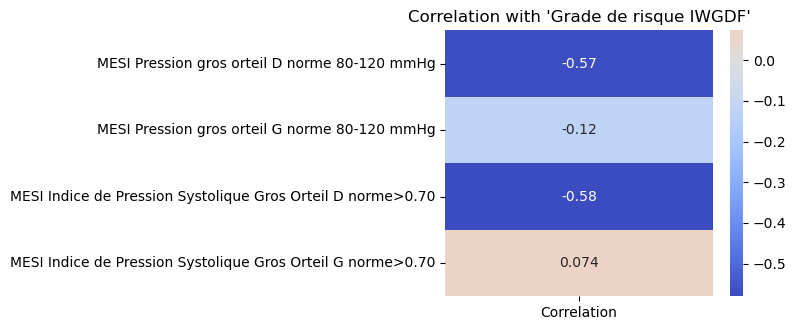

In [29]:
# Heatmap plot
import seaborn as sns 

corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
plt.figure(figsize=(8, len(labels_to_correlate)*0.6 + 1))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title(f"Correlation with '{reference_label}'")
plt.tight_layout()
plt.show()

#### 📊 Correlation Between MESI Measurements and IWGDF Risk Grade

| Measurement Label                                        | Correlation with IWGDF Grade | Interpretation                                                                          |
|----------------------------------------------------------|------------------------------|------------------------------------------------------------------------------------------|
| **MESI Pression gros orteil D** (Right big toe pressure) | **-0.574**                   | Moderate **negative** correlation – as pressure **decreases**, risk **increases**.      |
| **MESI Pression gros orteil G** (Left big toe pressure)  | **-0.120**                   | Very **weak negative** correlation – little meaningful relationship.                    |
| **MESI IPS Gros Orteil D** (Right toe-brachial index)    | **-0.580**                   | Moderate **negative** correlation – lower index values associated with **higher risk**. |
| **MESI IPS Gros Orteil G** (Left toe-brachial index)     | **+0.074**                   | Very **weak positive** correlation – no clear relationship.                             |

---

#### 📉 Clinical Interpretation

- **Stronger (negative) correlations** are seen on the **right foot** (pressure and index):
  - As perfusion or arterial health **worsens**, the IWGDF risk grade **increases**.
  - This aligns with vascular pathology progression and diabetic foot risk.

- **Weaker correlations on the left foot** may indicate:
  - **Measurement noise**, or
  - **Lower predictive value** of left foot metrics in this dataset.

---

#### 🧠 Summary

The **MESI values from the right big toe**, especially the **Toe-Brachial Index (TBI)**, show **moderate inverse correlation** with IWGDF diabetic foot risk.  
This suggests that lower pressure and lower index values are **meaningfully associated** with **higher clinical risk**, matching expectations in peripheral artery disease assessment


# new

| Catégorie              | Paramètres présents                       | Colonne(s)                                         |
| ---------------------- | --------------------------------------- | ------------------------------------------------- |
| Morphologie            | Épaisseur épiderme/derme, hypoderme, ROC | `US Épaisseur...`, `ROC ...`                       |
| Mécanique tissu        | Proxy par `Duromètre (shore A)`          | `Durometre ...`                                    |
| Contraintes mécaniques | Pressions maximales                      | `Pression MOYENNE DES MAX ...`, `Pression MAX ...` |
| Perfusion              | TcPO2 baseline, pente de reperfusion, TBI| `TCPO2 ...`, `MESI Indice...`                      |
| Strain interne         | ❌ non présent directement               | —                                                 |


| **Paramètre**                            | **Source / Mesure**            | **Corrélé au risque d’ulcère si…**                      |
|------------------------------------------|--------------------------------|----------------------------------------------------------|
| **Strain / déformation tissulaire**      | Modélisation FEM               | Shear strain élevée → risque augmenté                   |
| **Élasticité tissulaire (raideur)**      | SWE (Shear Wave Elastography)  | Tissu rigide → moins d’absorption de pression           |
| **Épaisseur tissulaire**                 | Échographie ou IRM             | Hypodermis mince → moins de protection mécanique        |
| **Pression plantaire max (Zebris)**      | Plateforme de pression         | Pression > seuil critique (ex. 300 N/cm²)               |
| **Rayon de courbure des os**             | Imagerie                       | Proéminences osseuses → transmission directe du stress  |
| **Durée/intensité de charge externe**    | Plateforme + observation       | Pression prolongée → ischémie locale                    |
| **Réperfusion post-ischémique (TcPO₂)**  | Capteur transcutané            | TcPO₂ faible après compression → récupération limitée   |
| **Amplitude MTP1 / talo-crurale**        | Goniomètre                     | Limitation de mouvement → surcharge compensatoire       |
| **Force musculaire (0–5)**               | Testing manuel                 | Muscles faibles → instabilité et surcharge anormale     |
| **Chaussures / orthèses adaptées ?**     | Observation                    | Non-adaptation → risque accru                           |
| **Autres zones d’hyperpression**         | Plateforme                     | Identifier les pressions compensatoires                 |


| **Type de variable**                                           | **Statistiques descriptives**                                            |
|---------------------------------------------------------------|---------------------------------------------------------------------------|
| **Variables continues** (pression, épaisseur, angles, TcPO₂…) | Moyenne, médiane, écart-type, min, max                                   |
| **Variables ordinales** (force musculaire 0–5)                | Mode, distribution                                                       |
| **Variables binaires** (orthèses adaptées ou non)            | Pourcentage, fréquence                                                   |
| **Pressions localisées** (HALLUX, TM5, SESA)                 | Moyennes comparées entre patients à risque vs non à risque (ex. test t)  |


| **Type d’analyse**                                            | **Objectif**                                                    |
|---------------------------------------------------------------|------------------------------------------------------------------|
| **Statistique descriptive**                                   | Résumer les données et identifier les tendances générales        |
| **Analyse de corrélation (Pearson/Spearman)**                 | Identifier les variables les plus liées au risque d’ulcération   |
| **Analyse comparative** (ex : patients avec vs sans ulcères)  | T-tests / ANOVA                                                  |
| **Analyse multivariée** (PCA, clustering)                     | Identifier des profils patients                                  |
| **Préparation pour un modèle prédictif**                      | Régression logistique / arbre de décision / Random Forest        |


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr


biomech_cols = [
    "Pression MOYENNE DES MAX SESA D (N/cm2) risque si >45N/cm2",
    "Pression  MOYENNE DES MAX HALLUX D (N/cm2) risque si >45N/cm2",
    "Pression MOYENNE DES MAX  TM5 D (N/cm2) risque si >45N/cm2",
    "Pression MOYENNE DES MAX  SESA G (N/cm2) risque si >45N/cm2",
    "Pression MOYENNE DES MAX HALLUX G (N/cm2) risque si >45N/cm2",
    "Pression MOYENNE DES MAX TM5 G (N/cm2) risque si >45N/cm2",
    "Amplitude flexion dorsale MTP1 D (degrés) norme 90°_  necessaire à la marche 50°) (180-X)",
    "Amplitude flexion dorsale MTP1 G (degrés) norme 90°_  necessaire à la marche 50°) (180-X)",
    "Amplitude talo crurale D (degrés) necessaire à la marche 13° _ norme 23° Center National for Disease control and prevention) (90-X)",
    "Amplitude talo crurale G (degrés) necessaire à la marche 13° _ norme 23° Center National for Disease control and prevention) (90-X)",
    "Testing des muscles releveurs du pied D 0/1/2/3/4/5",
    "Testing des muscles releveurs du pied G 0/1/2/3/4/5",
    "Testing des muscles fibulaires D 0/1/2/3/4/5",
    "Testing des muscles fibulaires G 0/1/2/3/4/5",
    "Testing du muscle jambier postérieur D 0/1/2/3/4/5",
    "Testing du muscle jambier postérieur G 0/1/2/3/4/5",
    # add more as needed
]

# Step 2: Initialize matrices for correlation and p-values
corr_matrix = pd.DataFrame(index=biomech_cols, columns=biomech_cols, dtype=float)
pval_matrix = pd.DataFrame(index=biomech_cols, columns=biomech_cols, dtype=float)

# Step 3: Compute pairwise correlations and p-values
for col1 in biomech_cols:
    for col2 in biomech_cols:
        # Drop missing values pairwise
        clean_data = df[[col1, col2]].dropna()
        if len(clean_data) > 2:
            corr, pval = pearsonr(clean_data[col1], clean_data[col2])
            corr_matrix.loc[col1, col2] = corr
            pval_matrix.loc[col1, col2] = pval
        else:
            corr_matrix.loc[col1, col2] = np.nan
            pval_matrix.loc[col1, col2] = np.nan

# Step 4: Extract significant correlations (p < 0.05 and correlation > threshold)
signif_corrs = []
alpha = 0.05
corr_threshold = 0.3  # example threshold to consider "meaningful"

for i in biomech_cols:
    for j in biomech_cols:
        if i != j:
            if (pval_matrix.loc[i, j] is not np.nan) and (pval_matrix.loc[i, j] < alpha) and (abs(corr_matrix.loc[i, j]) >= corr_threshold):
                signif_corrs.append((i, j, corr_matrix.loc[i, j], pval_matrix.loc[i, j]))

# Step 5: Print significant correlations
for (param1, param2, corr_val, p_val) in signif_corrs:
    print(f"{param1} <> {param2} : correlation={corr_val:.2f}, p-value={p_val:.4f}")


KeyError: "None of [Index(['Pression MOYENNE DES MAX SESA D (N/cm2) risque si >45N/cm2', 'Pression MOYENNE DES MAX SESA D (N/cm2) risque si >45N/cm2'], dtype='object')] are in the [columns]"

In [ ]:
biomech_rows = [
    "Pression MOYENNE DES MAX SESA D (N/cm2) risque si >45N/cm2",
    "Pression  MOYENNE DES MAX HALLUX D (N/cm2) risque si >45N/cm2",
    "Pression MOYENNE DES MAX  TM5 D (N/cm2) risque si >45N/cm2",
    "Pression MOYENNE DES MAX  SESA G (N/cm2) risque si >45N/cm2",
    "Pression MOYENNE DES MAX HALLUX G (N/cm2) risque si >45N/cm2",
    "Pression MOYENNE DES MAX TM5 G (N/cm2) risque si >45N/cm2",
    "Amplitude flexion dorsale MTP1 D (degrés) norme 90°_  necessaire à la marche 50°) (180-X)",
    "Amplitude flexion dorsale MTP1 G (degrés) norme 90°_  necessaire à la marche 50°) (180-X)",
    "Amplitude talo crurale D (degrés) necessaire à la marche 13° _ norme 23° Center National for Disease control and prevention) (90-X)",
    "Amplitude talo crurale G (degrés) necessaire à la marche 13° _ norme 23° Center National for Disease control and prevention) (90-X)",
    "Testing des muscles releveurs du pied D 0/1/2/3/4/5",
    "Testing des muscles releveurs du pied G 0/1/2/3/4/5",
    "Testing des muscles fibulaires D 0/1/2/3/4/5",
    "Testing des muscles fibulaires G 0/1/2/3/4/5",
    "Testing du muscle jambier postérieur D 0/1/2/3/4/5",
    "Testing du muscle jambier postérieur G 0/1/2/3/4/5",
]

In [ ]:
df = pd.read_csv("latest_data.csv", delimiter='\t')

In [152]:
import pandas as pd
import statsmodels.api as sm

# Read data
df = pd.read_excel("_CR HDJ 13.xlsx", sheet_name="DIAFOOT", header=None)
pressure_data = df.iloc[108:111, 1:4]  # R109–R111 = rows 108–110 in Python

# Label the rows
pressure_data.index = ['SESA', 'HALLUX', 'TM5']

# Transpose → each row = one patient
df_transposed = pressure_data.T
df_transposed = df_transposed.apply(pd.to_numeric, errors='coerce')
df_transposed = df_transposed.fillna(df_transposed.mean())  # Fill missing with mean

# Define predictors and target
X = df_transposed[['SESA', 'HALLUX']]  # independent variables
y = df_transposed['TM5']               # dependent variable

# Add constant term (for intercept)
X = sm.add_constant(X)

# Fit model
model = sm.OLS(y, X).fit()

# Summary output with p-values and R²
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    TM5   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 15 Jun 2025   Prob (F-statistic):                nan
Time:                        09:24:44   Log-Likelihood:                 90.631
No. Observations:                   3   AIC:                            -175.3
Df Residuals:                       0   BIC:                            -178.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        141.3821        inf          0        n

/home/hamiri/.local/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/home/hamiri/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/hamiri/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/hamiri/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In [151]:
df = pd.read_excel("_CR HDJ 13.xlsx", sheet_name="DIAFOOT", header=None)
pressure_data = df.iloc[108:111, 1:4]  # R109-R111, Colonnes B à R

# Column naming
pressure_data.index = ['SESA', 'HALLUX', 'TM5']

# Transpose the data so that each row represents one patient
df_transposed = pressure_data.T
df_transposed = df_transposed.apply(pd.to_numeric, errors='coerce')
df_transposed = df_transposed.fillna(df_transposed.mean())  # یا dropna()

# Calculate Pearson correlation matrix
correlation_matrix = df_transposed.corr(method='pearson')
print(correlation_matrix)


            SESA    HALLUX       TM5
SESA    1.000000 -0.756470 -0.009882
HALLUX -0.756470  1.000000 -0.646521
TM5    -0.009882 -0.646521  1.000000


🔗 Coefficients de corrélation :
           1         2         3
1  1.000000  0.400837 -0.852421
2  0.400837  1.000000  0.137333
3 -0.852421  0.137333  1.000000

📉 P-values associées :
           1         2         3
1  0.000000  0.737439  0.350267
2  0.737439  0.000000  0.912294
3  0.350267  0.912294  0.000000


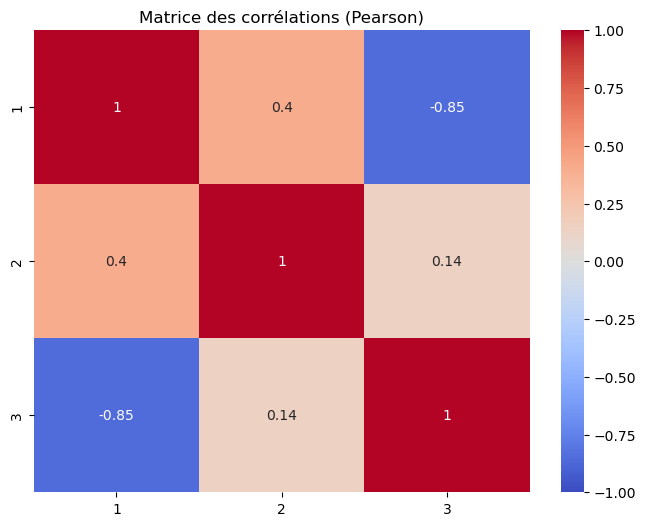

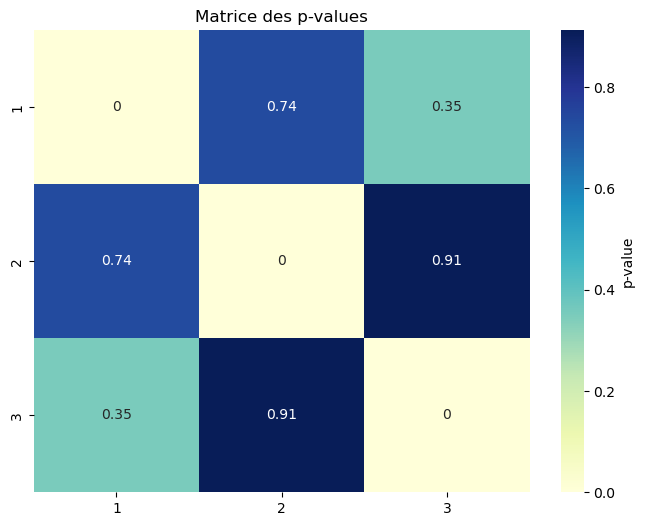

In [ ]:
df = pd.DataFrame(pressure_data)

# Calcul des corrélations de Pearson + p-values
def correlation_with_pvalues(df):
    cols = df.columns
    corr_matrix = pd.DataFrame(index=cols, columns=cols)
    pval_matrix = pd.DataFrame(index=cols, columns=cols)

    for col1 in cols:
        for col2 in cols:
            corr, pval = stats.pearsonr(df[col1], df[col2])
            corr_matrix.loc[col1, col2] = corr
            pval_matrix.loc[col1, col2] = pval
    return corr_matrix.astype(float), pval_matrix.astype(float)

corrs, pvals = correlation_with_pvalues(df)

# Affichage des matrices
print("🔗 Coefficients de corrélation :\n", corrs)
print("\n📉 P-values associées :\n", pvals)

# Visualisation heatmap des corrélations
plt.figure(figsize=(8, 6))
sns.heatmap(corrs, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice des corrélations (Pearson)")
plt.show()

# Heatmap des p-values
plt.figure(figsize=(8, 6))
sns.heatmap(pvals, annot=True, cmap='YlGnBu', cbar_kws={'label': 'p-value'})
plt.title("Matrice des p-values")
plt.show()

### Show the mechanical data:

In [142]:
import pandas as pd

# Read Excel file
df = pd.read_excel("_CR HDJ 13.xlsx", sheet_name="DIAFOOT", header=None)

# Extract pressure data: rows 109–111 (indexing starts at 0, so use 109:112), columns B–D (i.e., columns 1 to 4)
pressure_data = df.iloc[108:111, 1:4]

# Rename the index (rows)
pressure_data.index = ['SESA', 'HALLUX', 'TM5']

# Show the result
print(pressure_data)


         1   2   3
SESA    30  27  85
HALLUX  51  31  19
TM5     47  79  64


✅ Correlation matrix:
             SESA    HALLUX       TM5
SESA    1.000000 -0.756470 -0.009882
HALLUX -0.756470  1.000000 -0.646521
TM5    -0.009882 -0.646521  1.000000


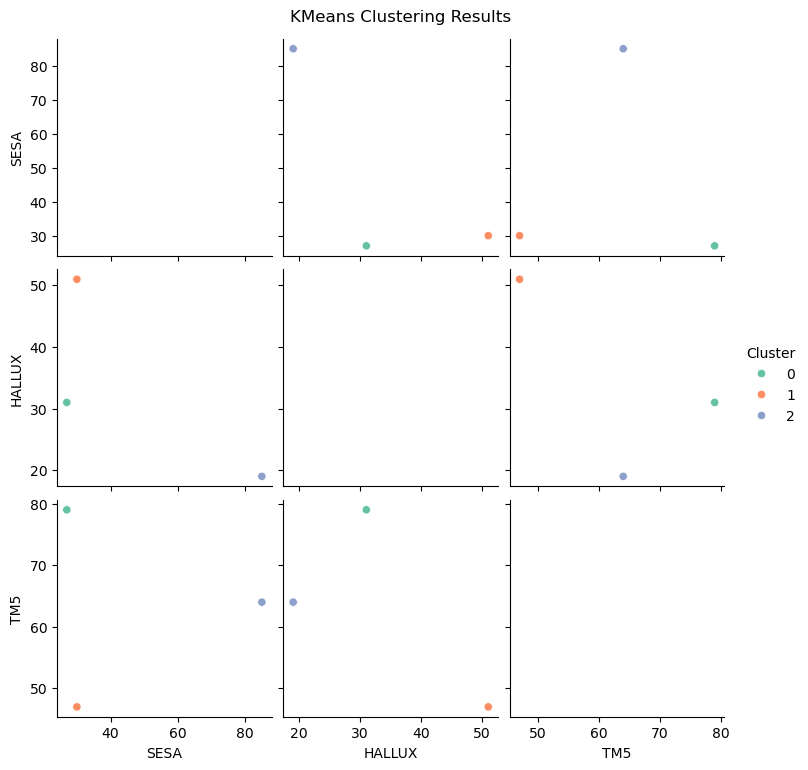

In [143]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Read Excel file
df = pd.read_excel("_CR HDJ 13.xlsx", sheet_name="DIAFOOT", header=None)
pressure_data = df.iloc[108:111, 1:4]  # R109-R111, Colonnes B à R
pressure_data.index = ['SESA', 'HALLUX', 'TM5']

# Transpose and convert to numeric
df_transposed = pressure_data.T
df_transposed = df_transposed.apply(pd.to_numeric, errors='coerce')

# Drop rows with any NaNs
df_transposed = df_transposed.dropna()

# Check if we still have data
if df_transposed.empty:
    print("❌ All rows contain NaNs — no data left after dropna().")
else:
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_transposed)

    # Perform clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)

    # Add cluster labels
    df_transposed['Cluster'] = clusters

    # Pearson correlation matrix (excluding the cluster column)
    corr_matrix = df_transposed.drop(columns='Cluster').corr(method='pearson')
    print("✅ Correlation matrix:\n", corr_matrix)

    # Visualize
    sns.pairplot(df_transposed, hue='Cluster', palette='Set2')
    plt.suptitle('KMeans Clustering Results', y=1.02)
    plt.show()


# cluster patients based on their IWGDF grades :

In [154]:
df = pd.read_excel("_CR HDJ 13.xlsx", sheet_name="DIAFOOT", header=None)

# Find the row with the risk grades
label_risk = "Grade de risque IWGDF"
row_risk = df[df[0].astype(str).str.strip().str.lower() == label_risk.lower()]
if row_risk.empty:
    raise ValueError(f"Label '{label_risk}' not found.")
idx_risk = row_risk.index[0]

# Extract and clean risk values
risk_values = pd.to_numeric(df.iloc[idx_risk, 1:], errors='coerce').dropna().astype(int)
patient_ids = pd.Series(range(1, len(risk_values) + 1), index=risk_values.index)

# Compute min, max, mean
min_iwgdf = risk_values.min()
max_iwgdf = risk_values.max()
mean_iwgdf = risk_values.mean()

# Group patients by risk level
low_moderate_patients = risk_values[risk_values.isin([0, 1])].index 
high_very_high_patients = risk_values[risk_values.isin([2, 3])].index 

# Output
print(f"IWGDF Grade: Ranges from {min_iwgdf} (low risk) to {max_iwgdf} (very high risk), with a mean of ~{mean_iwgdf:.1f}.")
print(f"➡️ Low or moderate risk (grade 0 or 1): patients {', '.join(map(str, low_moderate_patients.tolist()))}")
print(f"⚠️ High or very high risk (grade 2 or 3): patients {', '.join(map(str, high_very_high_patients.tolist()))}")

# Optional: frequency table
all_grades = pd.Series(index=[0,1,2,3], data=0)
freq = all_grades.add(risk_values.value_counts(), fill_value=0).astype(int).sort_index()

risk_labels = {
    0: "Low risk",
    1: "Moderate risk",
    2: "High risk",
    3: "Very high risk"
}

print("\nFrequency of each IWGDF risk grade:")
for grade, count in freq.items():
    print(f"Grade {grade} ({risk_labels[grade]}): {count} patient(s)")


IWGDF Grade: Ranges from 0 (low risk) to 3 (very high risk), with a mean of ~1.2.
➡️ Low or moderate risk (grade 0 or 1): patients 1, 3, 4, 10, 12, 13, 15, 16, 17, 18, 19, 20
⚠️ High or very high risk (grade 2 or 3): patients 2, 5, 6, 7, 8, 9, 11, 14

Frequency of each IWGDF risk grade:
Grade 0 (Low risk): 11 patient(s)
Grade 1 (Moderate risk): 1 patient(s)
Grade 2 (High risk): 1 patient(s)
Grade 3 (Very high risk): 7 patient(s)


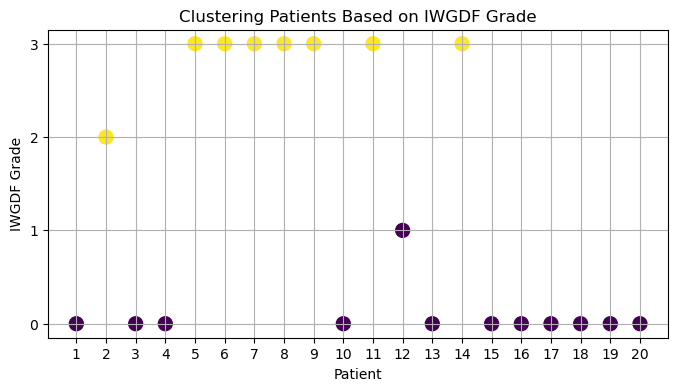

In [160]:
from sklearn.cluster import KMeans

df = pd.read_excel("_CR HDJ 13.xlsx", sheet_name="DIAFOOT", header=None)

# Prepare data for clustering (reshape into 2D)
X = risk_values.values.reshape(-1, 1)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Add clustering results to a DataFrame
results = pd.DataFrame({
    "Patient": patient_ids.values,
    "IWGDF_Grade": risk_values.values,
    "Cluster": clusters
})

plt.figure(figsize=(8, 4))
plt.scatter(results["Patient"], results["IWGDF_Grade"], c=results["Cluster"], cmap="viridis", s=100)
plt.xlabel("Patient")
plt.ylabel("IWGDF Grade")
plt.title("Clustering Patients Based on IWGDF Grade")
plt.xticks(ticks=results["Patient"], labels=results["Patient"])
plt.yticks(ticks=[0, 1, 2, 3], labels=[0, 1, 2, 3])
plt.grid(True)
plt.show()

## 🩺 Group patients into two groups:

- Group A: Grades 0 or 1 (low to moderate risk) 😊👍

- Group B: Grades 2 or 3 (high to very high risk) ⚠️😟

## Paramètres morphologiques :


#### Compare these two groups from the thickness data (ED): 

👥 Patient distribution:
➡️ Group A (0 ou 1) : 1, 3, 4, 10, 12, 13, 15, 16, 17, 18, 19, 20
⚠️ Group B (2 ou 3) : 2, 5, 6, 7, 8, 9, 11, 14

📊 t-test analysis between Group A and Group B:

ED SESA D (mm) → p-value = nan
ED HALLUX D (mm) → p-value = nan
ED TM5 D (mm) → p-value = nan
ED Autre D (mm) → p-value = nan
ED SESA G (mm) → p-value = nan
ED HALLUX G (mm) → p-value = nan
ED TM5 G (mm) → p-value = nan
ED Autre G (mm) → p-value = nan


/tmp/ipykernel_162307/1565132575.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_thickness, x="Group", y="ED SESA D (mm)", palette="pastel")
/tmp/ipykernel_162307/1565132575.py:64: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  plt.tight_layout()
/home/hamiri/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


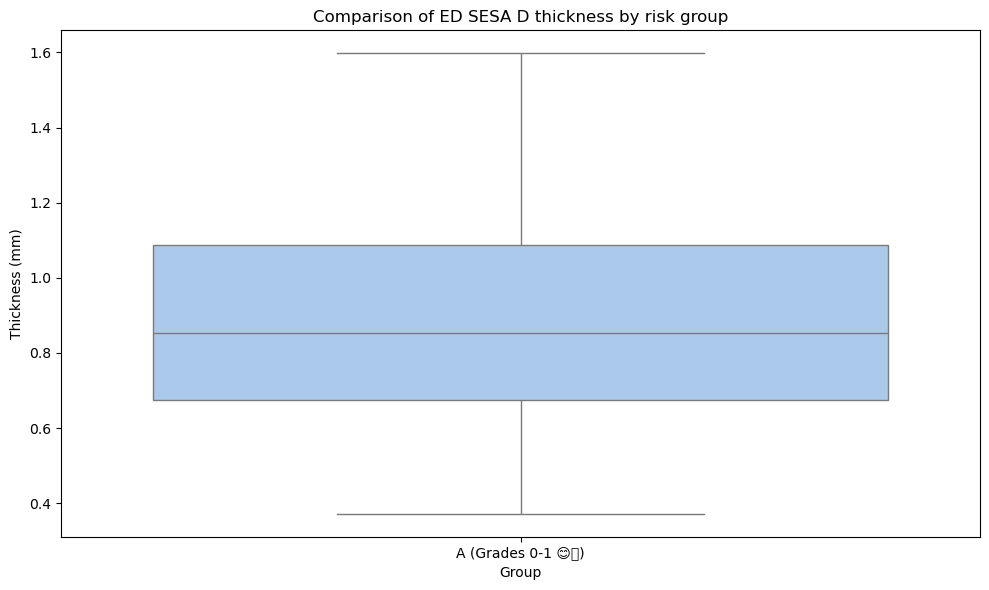


📈 Correlation table:

                  ED SESA D (mm)  ED HALLUX D (mm)  ED TM5 D (mm)  \
ED SESA D (mm)          1.000000         -0.177753      -0.663721   
ED HALLUX D (mm)       -0.177753          1.000000       0.087705   
ED TM5 D (mm)          -0.663721          0.087705       1.000000   
ED Autre D (mm)         0.036994         -0.209263       0.417766   
ED SESA G (mm)          0.148685         -0.354297       0.428152   
ED HALLUX G (mm)       -0.272117         -0.355563       0.765179   
ED TM5 G (mm)           0.311086         -0.002740      -0.022820   
ED Autre G (mm)        -0.084360         -0.274990       0.435130   
Grade                  -0.165123         -0.002532      -0.208668   

                  ED Autre D (mm)  ED SESA G (mm)  ED HALLUX G (mm)  \
ED SESA D (mm)           0.036994        0.148685         -0.272117   
ED HALLUX D (mm)        -0.209263       -0.354297         -0.355563   
ED TM5 D (mm)            0.417766        0.428152          0.765179   
ED

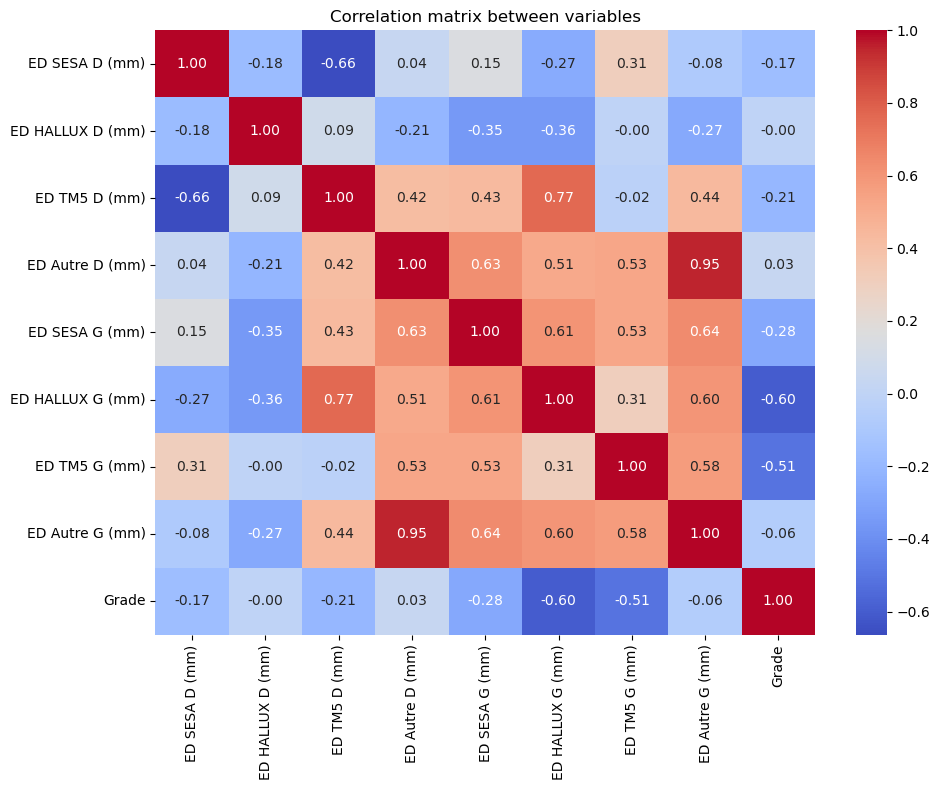


📉 Linear regression coefficients:
            Feature  Coefficient
5  ED HALLUX G (mm)    -0.408181
3   ED Autre D (mm)     0.281327
6     ED TM5 G (mm)    -0.146799
0    ED SESA D (mm)    -0.131349
1  ED HALLUX D (mm)    -0.111892
7   ED Autre G (mm)    -0.054707
4    ED SESA G (mm)     0.051150
2     ED TM5 D (mm)     0.046982


/tmp/ipykernel_162307/1565132575.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coeff_df, palette="viridis")


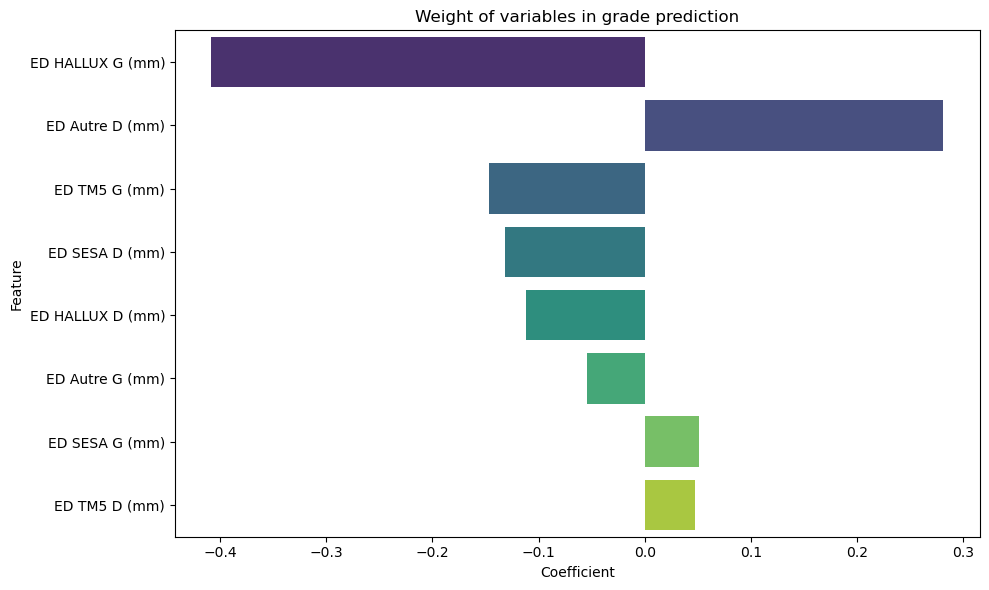

In [162]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load basic data ---
df = pd.read_excel("_CR HDJ 13.xlsx", sheet_name="DIAFOOT", header=None)

# --- Retrieve IWGDF Risk Grades ---
label_risk = "Grade de risque IWGDF"
row_risk = df[df[0].astype(str).str.strip().str.lower() == label_risk.lower()]
if row_risk.empty:
    raise ValueError(f"Label '{label_risk}' not found.")
idx_risk = row_risk.index[0]
risk_values = pd.to_numeric(df.iloc[idx_risk, 1:], errors='coerce').dropna().astype(int)
patient_numbers = pd.Series(range(1, len(risk_values) + 1), index=risk_values.index)

# --- Extraction of ED thickness data ---
pressure_data = df.iloc[126:134, 1:1+len(risk_values)]
pressure_data.index = [
    "ED SESA D (mm)",
    "ED HALLUX D (mm)",
    "ED TM5 D (mm)",
    "ED Autre D (mm)",
    "ED SESA G (mm)",
    "ED HALLUX G (mm)",
    "ED TM5 G (mm)",
    "ED Autre G (mm)"
]

df_thickness = pressure_data.T
df_thickness = df_thickness.apply(pd.to_numeric, errors='coerce')
df_thickness = df_thickness.dropna()
df_thickness['Grade'] = risk_values.loc[df_thickness.index].values

# --- Creation of groups A and B ---
df_thickness['Group'] = df_thickness['Grade'].apply(
    lambda x: 'A (Grades 0-1 😊👍)' if x in [0, 1] else 'B (Grades 2-3 ⚠️)'
)


group_a = df_thickness[df_thickness['Group'].str.startswith('A')]
group_b = df_thickness[df_thickness['Group'].str.startswith('B')]

print("👥 Patient distribution:")
print(f"➡️ Group A (0 ou 1) : {', '.join(map(str, patient_numbers[risk_values.isin([0,1])].tolist()))}")
print(f"⚠️ Group B (2 ou 3) : {', '.join(map(str, patient_numbers[risk_values.isin([2,3])].tolist()))}")

# --- 📊 Comparative analysis between Group A and Group B ---
print("\n📊 t-test analysis between Group A and Group B:\n")
for col in df_thickness.columns[:-2]: # exclude 'Grade' and 'Group'
    t_stat, p_value = ttest_ind(group_a[col], group_b[col], equal_var=False)
    print(f"{col} → p-value = {p_value:.4f}")

# --- Boxplot visualization (example on a variable) ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_thickness, x="Group", y="ED SESA D (mm)", palette="pastel")
plt.title("Comparison of ED SESA D thickness by risk group")
plt.xlabel("Group")
plt.ylabel("Thickness (mm)")
plt.tight_layout()
plt.show()

# --- Correlation Matrix ---
print("\n📈 Correlation table:\n")
correlation_matrix = df_thickness.drop(columns=['Group']).corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix between variables")
plt.tight_layout()
plt.show()

# --- Linear Regression to Predict Grade ---
X = df_thickness.drop(columns=['Grade', 'Group'])
y = df_thickness['Grade']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LinearRegression()
model.fit(X_scaled, y)

coeff_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("\n📉 Linear regression coefficients:")
print(coeff_df)

plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=coeff_df, palette="viridis")
plt.title("Weight of variables in grade prediction")
plt.tight_layout()
plt.show()


### for rows 135–142 (Hypodermis thickness data) : 


👥 Patient distribution (Hypodermis Data):
➡️ Group A (0 or 1): 1, 3, 4, 10, 12, 13, 15, 16, 17, 18, 19, 20
⚠️ Group B (2 or 3): 2, 5, 6, 7, 8, 9, 11, 14

📊 T-test results for Hypodermis Thickness Data:

US Hypoderme SESA R (mm) → p-value = nan
US Hypoderme HALLUX R (mm) → p-value = nan
US Hypoderme TM5 R (mm) → p-value = nan
US Hypoderme Other R (mm) → p-value = nan
US Hypoderme SESA L (mm) → p-value = nan
US Hypoderme HALLUX L (mm) → p-value = nan
US Hypoderme TM5 L (mm) → p-value = nan
US Hypoderme Other L (mm) → p-value = nan


/tmp/ipykernel_162307/841782269.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_hypoderm, x="Group", y="US Hypoderme SESA R (mm)", palette="Set2")
/tmp/ipykernel_162307/841782269.py:43: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  plt.tight_layout()
/home/hamiri/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


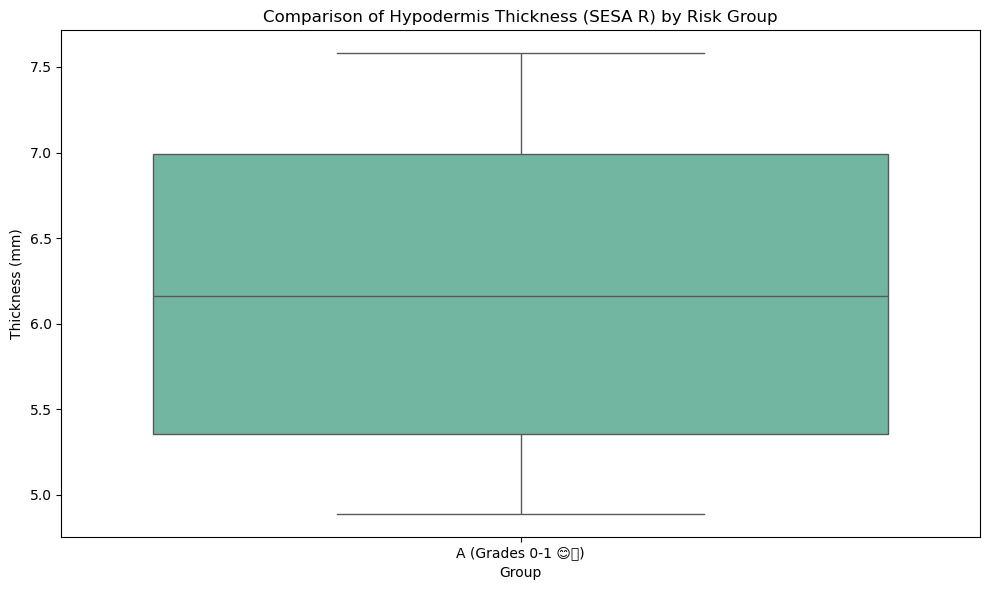


📈 Correlation matrix (Hypodermis):

                            US Hypoderme SESA R (mm)  \
US Hypoderme SESA R (mm)                    1.000000   
US Hypoderme HALLUX R (mm)                 -0.216700   
US Hypoderme TM5 R (mm)                    -0.354210   
US Hypoderme Other R (mm)                  -0.070026   
US Hypoderme SESA L (mm)                    0.481528   
US Hypoderme HALLUX L (mm)                  0.145392   
US Hypoderme TM5 L (mm)                     0.118511   
US Hypoderme Other L (mm)                   0.261388   
Grade                                       0.533331   

                            US Hypoderme HALLUX R (mm)  \
US Hypoderme SESA R (mm)                     -0.216700   
US Hypoderme HALLUX R (mm)                    1.000000   
US Hypoderme TM5 R (mm)                       0.651882   
US Hypoderme Other R (mm)                     0.945105   
US Hypoderme SESA L (mm)                      0.677549   
US Hypoderme HALLUX L (mm)                    0.663645

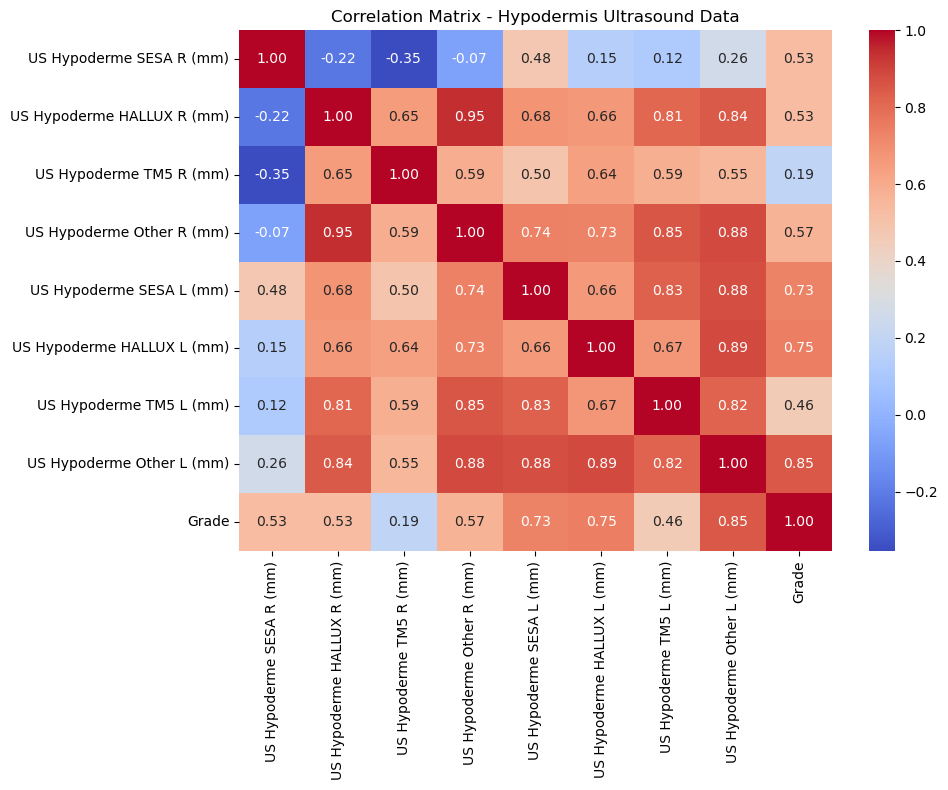


📉 Linear Regression Coefficients (Hypodermis):
                      Feature  Coefficient
7   US Hypoderme Other L (mm)     0.299675
4    US Hypoderme SESA L (mm)     0.223301
3   US Hypoderme Other R (mm)    -0.208162
6     US Hypoderme TM5 L (mm)    -0.205768
2     US Hypoderme TM5 R (mm)    -0.179692
5  US Hypoderme HALLUX L (mm)     0.155942
1  US Hypoderme HALLUX R (mm)     0.136999
0    US Hypoderme SESA R (mm)    -0.056299


/tmp/ipykernel_162307/841782269.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coeff_df_hypo, palette="magma")


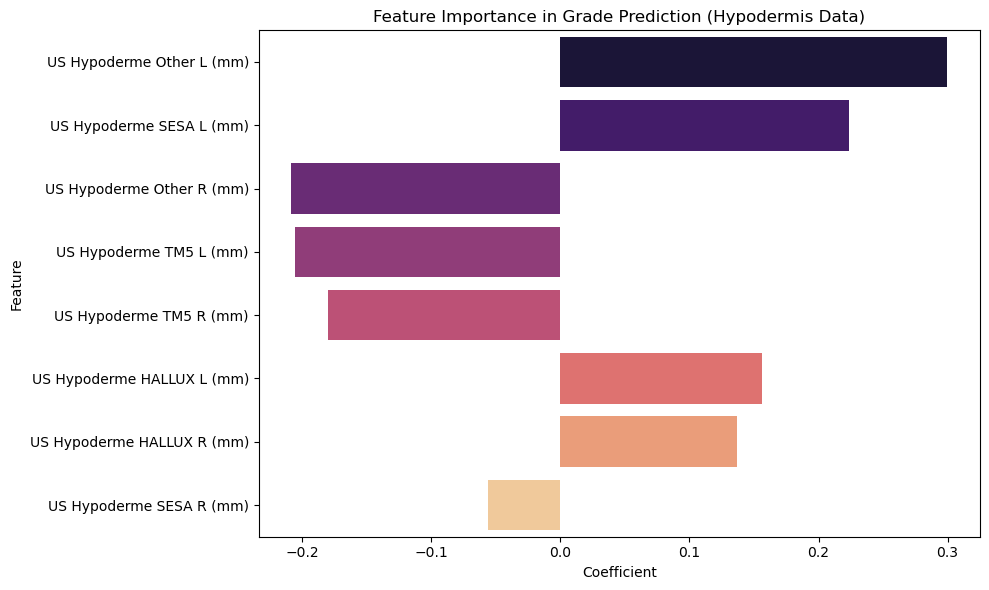

In [164]:
# --- 📥 Load hypodermis ultrasound thickness data (rows 135 to 142) ---
hypoderm_data = df.iloc[135:143, 1:1+len(risk_values)]
hypoderm_data.index = [
    "US Hypoderme SESA R (mm)",
    "US Hypoderme HALLUX R (mm)",
    "US Hypoderme TM5 R (mm)",
    "US Hypoderme Other R (mm)",
    "US Hypoderme SESA L (mm)",
    "US Hypoderme HALLUX L (mm)",
    "US Hypoderme TM5 L (mm)",
    "US Hypoderme Other L (mm)"
]

# --- Transpose and clean ---
df_hypoderm = hypoderm_data.T
df_hypoderm = df_hypoderm.apply(pd.to_numeric, errors='coerce')
df_hypoderm = df_hypoderm.dropna()
df_hypoderm['Grade'] = risk_values.loc[df_hypoderm.index].values
df_hypoderm['Group'] = df_hypoderm['Grade'].apply(
    lambda x: 'A (Grades 0-1 😊👍)' if x in [0, 1] else 'B (Grades 2-3 ⚠️)'
)

# --- Split into groups ---
group_a_hypo = df_hypoderm[df_hypoderm['Group'].str.startswith('A')]
group_b_hypo = df_hypoderm[df_hypoderm['Group'].str.startswith('B')]

print("\n👥 Patient distribution (Hypodermis Data):")
print(f"➡️ Group A (0 or 1): {', '.join(map(str, patient_numbers[risk_values.isin([0,1])].tolist()))}")
print(f"⚠️ Group B (2 or 3): {', '.join(map(str, patient_numbers[risk_values.isin([2,3])].tolist()))}")

# --- 📊 T-test between Group A and Group B (Hypodermis) ---
print("\n📊 T-test results for Hypodermis Thickness Data:\n")
for col in df_hypoderm.columns[:-2]:  # exclude 'Grade' and 'Group'
    t_stat, p_value = ttest_ind(group_a_hypo[col], group_b_hypo[col], equal_var=False)
    print(f"{col} → p-value = {p_value:.4f}")

# --- 📦 Boxplot for one variable (example: SESA R) ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_hypoderm, x="Group", y="US Hypoderme SESA R (mm)", palette="Set2")
plt.title("Comparison of Hypodermis Thickness (SESA R) by Risk Group")
plt.xlabel("Group")
plt.ylabel("Thickness (mm)")
plt.tight_layout()
plt.show()

# --- 🔗 Correlation matrix ---
print("\n📈 Correlation matrix (Hypodermis):\n")
correlation_matrix_hypo = df_hypoderm.drop(columns=['Group']).corr()
print(correlation_matrix_hypo)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_hypo, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix - Hypodermis Ultrasound Data")
plt.tight_layout()
plt.show()

# --- 🔁 Linear regression to predict grade ---
X_hypo = df_hypoderm.drop(columns=['Grade', 'Group'])
y_hypo = df_hypoderm['Grade']

scaler_hypo = StandardScaler()
X_hypo_scaled = scaler_hypo.fit_transform(X_hypo)

model_hypo = LinearRegression()
model_hypo.fit(X_hypo_scaled, y_hypo)

coeff_df_hypo = pd.DataFrame({
    "Feature": X_hypo.columns,
    "Coefficient": model_hypo.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("\n📉 Linear Regression Coefficients (Hypodermis):")
print(coeff_df_hypo)

plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=coeff_df_hypo, palette="magma")
plt.title("Feature Importance in Grade Prediction (Hypodermis Data)")
plt.tight_layout()
plt.show()


### Combine ED and Hypodermis Data for One Unified Analysis


📊 T-test Results (Combined ED + Hypodermis):

ED SESA R (mm) → p-value = nan
ED HALLUX R (mm) → p-value = nan
ED TM5 R (mm) → p-value = nan
ED Other R (mm) → p-value = nan
ED SESA L (mm) → p-value = nan
ED HALLUX L (mm) → p-value = nan
ED TM5 L (mm) → p-value = nan
ED Other L (mm) → p-value = nan
US Hypoderme SESA R (mm) → p-value = nan
US Hypoderme HALLUX R (mm) → p-value = nan
US Hypoderme TM5 R (mm) → p-value = nan
US Hypoderme Other R (mm) → p-value = nan
US Hypoderme SESA L (mm) → p-value = nan
US Hypoderme HALLUX L (mm) → p-value = nan
US Hypoderme TM5 L (mm) → p-value = nan
US Hypoderme Other L (mm) → p-value = nan

📈 Correlation Matrix (Combined Data):

                            ED SESA R (mm)  ED HALLUX R (mm)  ED TM5 R (mm)  \
ED SESA R (mm)                    1.000000         -0.177753      -0.663721   
ED HALLUX R (mm)                 -0.177753          1.000000       0.087705   
ED TM5 R (mm)                    -0.663721          0.087705       1.000000   
ED Other R (m

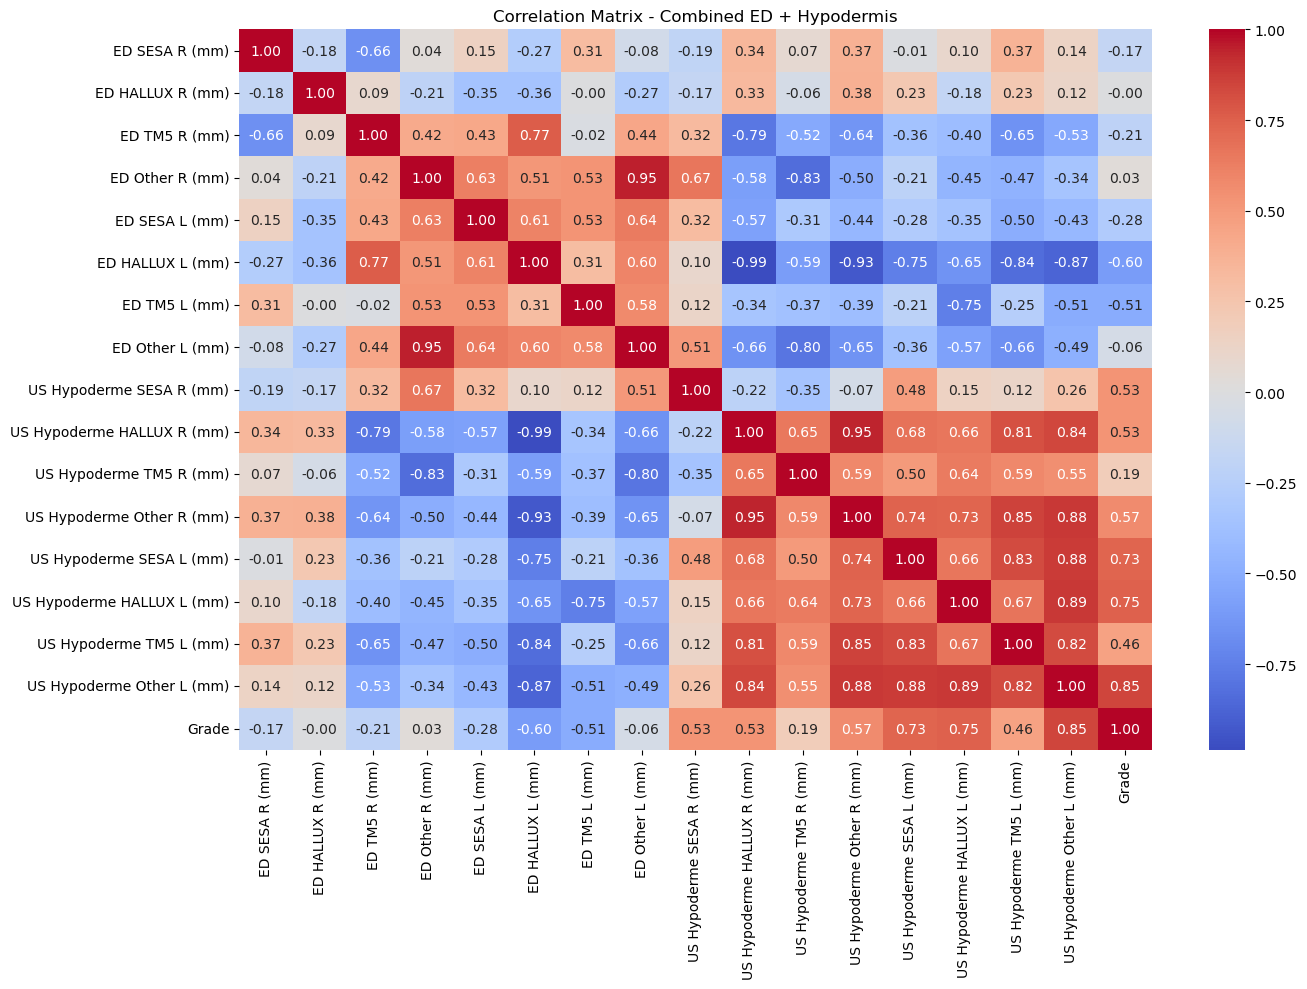


📉 Linear Regression Coefficients (Combined Features):
                       Feature  Coefficient
7              ED Other L (mm)     0.105231
15   US Hypoderme Other L (mm)     0.104622
0               ED SESA R (mm)    -0.086479
5             ED HALLUX L (mm)    -0.080240
6                ED TM5 L (mm)    -0.079350
13  US Hypoderme HALLUX L (mm)     0.078192
9   US Hypoderme HALLUX R (mm)     0.071350
14     US Hypoderme TM5 L (mm)    -0.070047
3              ED Other R (mm)     0.067452
8     US Hypoderme SESA R (mm)     0.047795
12    US Hypoderme SESA L (mm)     0.037626
11   US Hypoderme Other R (mm)     0.036578
1             ED HALLUX R (mm)    -0.027946
10     US Hypoderme TM5 R (mm)    -0.023934
2                ED TM5 R (mm)    -0.023783
4               ED SESA L (mm)    -0.016749


/tmp/ipykernel_162307/1689381160.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coeff_combined, palette="cubehelix")


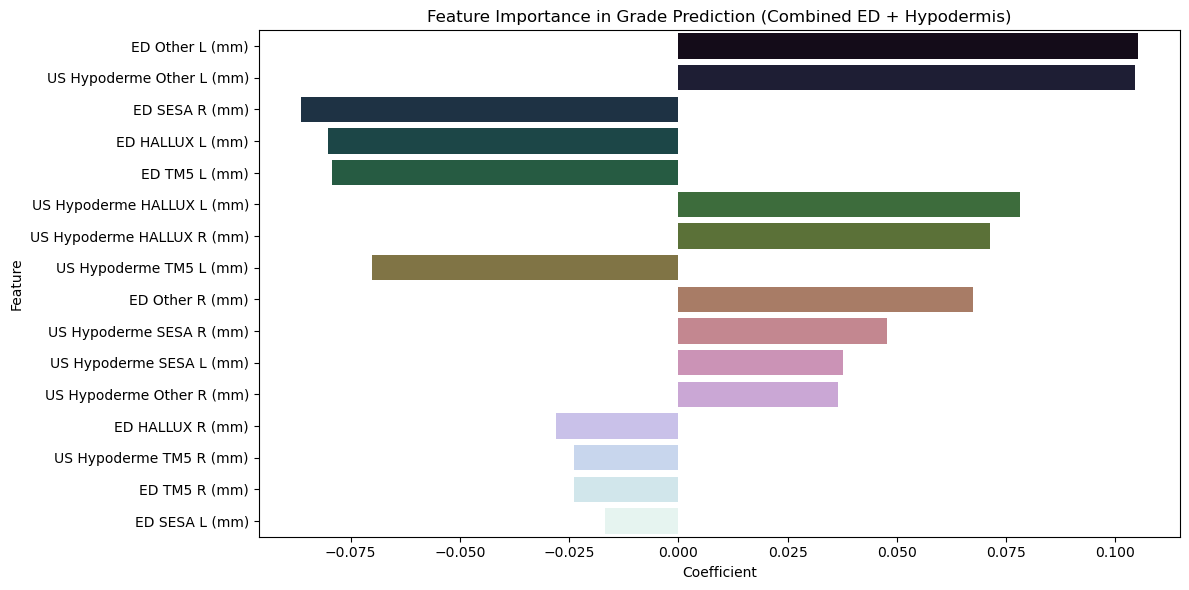

In [166]:
# --- Load ED thickness data (already done earlier) ---
ed_data = df.iloc[126:134, 1:1+len(risk_values)]
ed_data.index = [
    "ED SESA R (mm)",
    "ED HALLUX R (mm)",
    "ED TM5 R (mm)",
    "ED Other R (mm)",
    "ED SESA L (mm)",
    "ED HALLUX L (mm)",
    "ED TM5 L (mm)",
    "ED Other L (mm)"
]
df_ed = ed_data.T.apply(pd.to_numeric, errors='coerce')

# --- Load hypodermis ultrasound data ---
hypoderm_data = df.iloc[135:143, 1:1+len(risk_values)]
hypoderm_data.index = [
    "US Hypoderme SESA R (mm)",
    "US Hypoderme HALLUX R (mm)",
    "US Hypoderme TM5 R (mm)",
    "US Hypoderme Other R (mm)",
    "US Hypoderme SESA L (mm)",
    "US Hypoderme HALLUX L (mm)",
    "US Hypoderme TM5 L (mm)",
    "US Hypoderme Other L (mm)"
]
df_hypo = hypoderm_data.T.apply(pd.to_numeric, errors='coerce')

# --- Combine both dataframes ---
df_combined = pd.concat([df_ed, df_hypo], axis=1)

# --- Drop rows with any NaNs ---
df_combined = df_combined.dropna()

# --- Add Grade and Group columns ---
df_combined['Grade'] = risk_values.loc[df_combined.index].values
df_combined['Group'] = df_combined['Grade'].apply(
    lambda x: 'A (Grades 0-1 😊👍)' if x in [0, 1] else 'B (Grades 2-3 ⚠️)'
)

# --- Split for group comparison ---
group_a_combined = df_combined[df_combined['Group'].str.startswith('A')]
group_b_combined = df_combined[df_combined['Group'].str.startswith('B')]

# --- 📊 T-tests for all variables ---
print("\n📊 T-test Results (Combined ED + Hypodermis):\n")
for col in df_combined.columns[:-2]:  # exclude 'Grade' and 'Group'
    t_stat, p_value = ttest_ind(group_a_combined[col], group_b_combined[col], equal_var=False)
    print(f"{col} → p-value = {p_value:.4f}")

# --- 🔗 Correlation matrix ---
print("\n📈 Correlation Matrix (Combined Data):\n")
corr_combined = df_combined.drop(columns=["Group"]).corr()
print(corr_combined)

plt.figure(figsize=(14, 10))
sns.heatmap(corr_combined, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix - Combined ED + Hypodermis")
plt.tight_layout()
plt.show()

# --- 🔁 Linear regression on combined features ---
X_combined = df_combined.drop(columns=['Grade', 'Group'])
y_combined = df_combined['Grade']

scaler_combined = StandardScaler()
X_combined_scaled = scaler_combined.fit_transform(X_combined)

model_combined = LinearRegression()
model_combined.fit(X_combined_scaled, y_combined)

coeff_combined = pd.DataFrame({
    "Feature": X_combined.columns,
    "Coefficient": model_combined.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("\n📉 Linear Regression Coefficients (Combined Features):")
print(coeff_combined)

plt.figure(figsize=(12, 6))
sns.barplot(x="Coefficient", y="Feature", data=coeff_combined, palette="cubehelix")
plt.title("Feature Importance in Grade Prediction (Combined ED + Hypodermis)")
plt.tight_layout()
plt.show()


### ✅ Workflow Progress

| Step           | Description                                         |
|----------------|-----------------------------------------------------|
| ✅ Data Loading | Loads both ED and hypodermis ultrasound data        |
| ✅ Merging      | Combines all 16 features into a single dataset      |
| ✅ Cleaning     | Drops rows with any NaNs                            |
| ✅ Labeling     | Adds `Grade` and `Group A/B`                        |
| ✅ T-Test       | Compares group A vs B for each variable             |
| ✅ Correlation  | Full matrix with `seaborn` heatmap                  |
| ✅ Regression   | Linear model to predict grade based on all features |


### analyze ROC (Receiver Operating Characteristic) data from rows 151–158


📊 T-test Results (ROC Data):

ROC SESA R → p-value = nan
ROC HALLUX R → p-value = nan
ROC TM5 R → p-value = nan
ROC Other R → p-value = nan
ROC SESA L → p-value = nan
ROC HALLUX L → p-value = nan
ROC TM5 L → p-value = nan
ROC Other L → p-value = nan


/tmp/ipykernel_162307/3279994094.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_roc, x="Group", y="ROC SESA R", palette="pastel")
/tmp/ipykernel_162307/3279994094.py:41: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  plt.tight_layout()
/home/hamiri/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


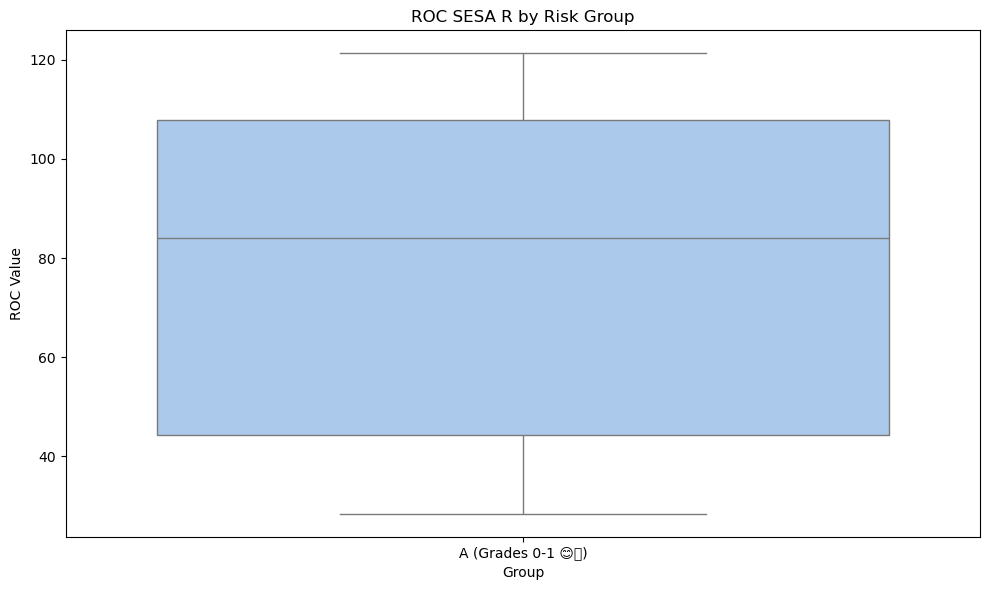


📈 Correlation Matrix (ROC Data):

              ROC SESA R  ROC HALLUX R  ROC TM5 R  ROC Other R  ROC SESA L  \
ROC SESA R      1.000000      0.816276  -0.508109     0.656564    0.924569   
ROC HALLUX R    0.816276      1.000000  -0.110861     0.674643    0.720714   
ROC TM5 R      -0.508109     -0.110861   1.000000     0.050613   -0.425956   
ROC Other R     0.656564      0.674643   0.050613     1.000000    0.851025   
ROC SESA L      0.924569      0.720714  -0.425956     0.851025    1.000000   
ROC HALLUX L   -0.053223     -0.066153   0.588557     0.558463    0.222410   
ROC TM5 L       0.776107      0.805487  -0.080305     0.972085    0.907465   
ROC Other L     0.262786      0.504634   0.458258     0.185543    0.118119   
Grade           0.544372      0.402803  -0.339973     0.802383    0.770279   

              ROC HALLUX L  ROC TM5 L  ROC Other L     Grade  
ROC SESA R       -0.053223   0.776107     0.262786  0.544372  
ROC HALLUX R     -0.066153   0.805487     0.504634  0.4028

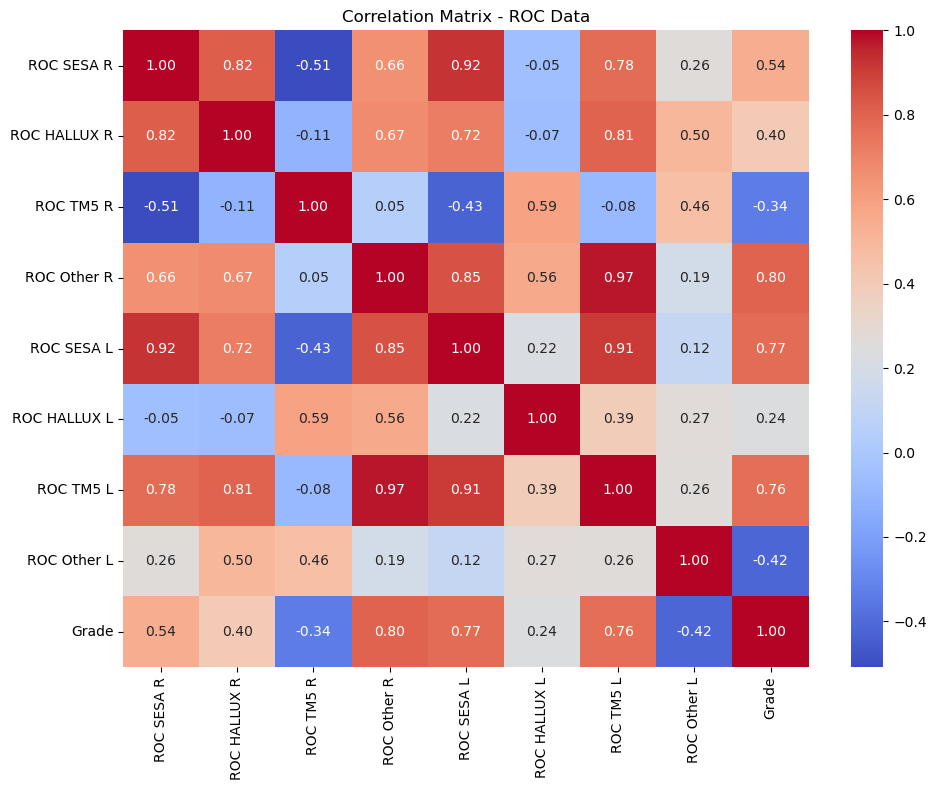


📉 Linear Regression Coefficients (ROC Data):
        Feature  Coefficient
7   ROC Other L    -0.251249
3   ROC Other R     0.152544
6     ROC TM5 L     0.111036
4    ROC SESA L     0.062650
1  ROC HALLUX R     0.041739
2     ROC TM5 R     0.017997
5  ROC HALLUX L     0.004997
0    ROC SESA R    -0.000015


/tmp/ipykernel_162307/3279994094.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coeff_df_roc, palette="crest")


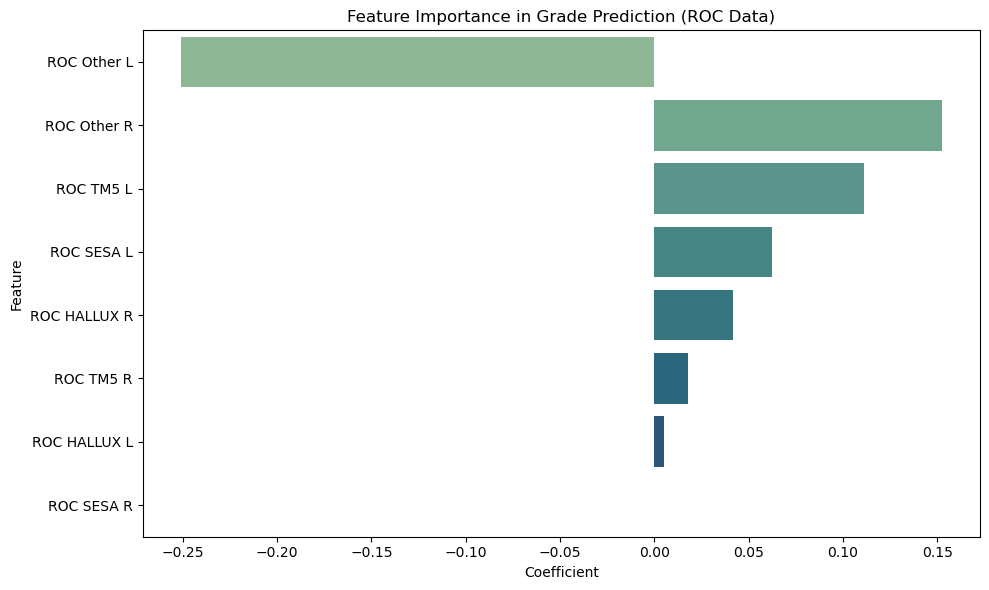

In [168]:
# --- 📥 Load ROC data (rows 151 to 158) ---
roc_data = df.iloc[151:159, 1:1+len(risk_values)]
roc_data.index = [
    "ROC SESA R",
    "ROC HALLUX R",
    "ROC TM5 R",
    "ROC Other R",
    "ROC SESA L",
    "ROC HALLUX L",
    "ROC TM5 L",
    "ROC Other L"
]

# --- Transpose and clean ---
df_roc = roc_data.T
df_roc = df_roc.apply(pd.to_numeric, errors='coerce')
df_roc = df_roc.dropna()

# --- Add Grade and Group ---
df_roc['Grade'] = risk_values.loc[df_roc.index].values
df_roc['Group'] = df_roc['Grade'].apply(
    lambda x: 'A (Grades 0-1 😊👍)' if x in [0, 1] else 'B (Grades 2-3 ⚠️)'
)

# --- Group by A and B ---
group_a_roc = df_roc[df_roc['Group'].str.startswith('A')]
group_b_roc = df_roc[df_roc['Group'].str.startswith('B')]

# --- 📊 T-tests ---
print("\n📊 T-test Results (ROC Data):\n")
for col in df_roc.columns[:-2]:  # skip 'Grade' and 'Group'
    t_stat, p_value = ttest_ind(group_a_roc[col], group_b_roc[col], equal_var=False)
    print(f"{col} → p-value = {p_value:.4f}")

# --- 📦 Example Boxplot (ROC SESA R) ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_roc, x="Group", y="ROC SESA R", palette="pastel")
plt.title("ROC SESA R by Risk Group")
plt.xlabel("Group")
plt.ylabel("ROC Value")
plt.tight_layout()
plt.show()

# --- 🔗 Correlation Matrix ---
print("\n📈 Correlation Matrix (ROC Data):\n")
corr_roc = df_roc.drop(columns=['Group']).corr()
print(corr_roc)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_roc, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix - ROC Data")
plt.tight_layout()
plt.show()

# --- 🔁 Linear Regression to Predict Grade ---
X_roc = df_roc.drop(columns=['Grade', 'Group'])
y_roc = df_roc['Grade']

scaler_roc = StandardScaler()
X_roc_scaled = scaler_roc.fit_transform(X_roc)

model_roc = LinearRegression()
model_roc.fit(X_roc_scaled, y_roc)

coeff_df_roc = pd.DataFrame({
    "Feature": X_roc.columns,
    "Coefficient": model_roc.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("\n📉 Linear Regression Coefficients (ROC Data):")
print(coeff_df_roc)

plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=coeff_df_roc, palette="crest")
plt.title("Feature Importance in Grade Prediction (ROC Data)")
plt.tight_layout()
plt.show()


| Step           | Description                                 |
| -------------- | ------------------------------------------- |
| 📥 **Data**        | Extracted from rows 151–158                 |
| 🧼 **Clean**       | Converted to numeric + dropped missing rows |
| 🏷️ **Labels**     | Added `Grade` and `Group`                   |
| 📊 **Stats**       | T-tests between Group A and B               |
| 📈 **Correlation** | Matrix + heatmap                            |
| 🔁 **Regression**  | Linear model trained on ROC features        |


## Analyze the MESI Big Toe Pressure and Ankle-Brachial Pressure Index values ​​for lines 36 to 39


📊 T-test Results (MESI Data):

MESI Pression gros orteil D → pas assez de données pour le test (nA=0, nB=0)
MESI Pression gros orteil G → pas assez de données pour le test (nA=0, nB=0)
MESI IPS gros orteil D → pas assez de données pour le test (nA=0, nB=0)
MESI IPS gros orteil G → pas assez de données pour le test (nA=0, nB=0)


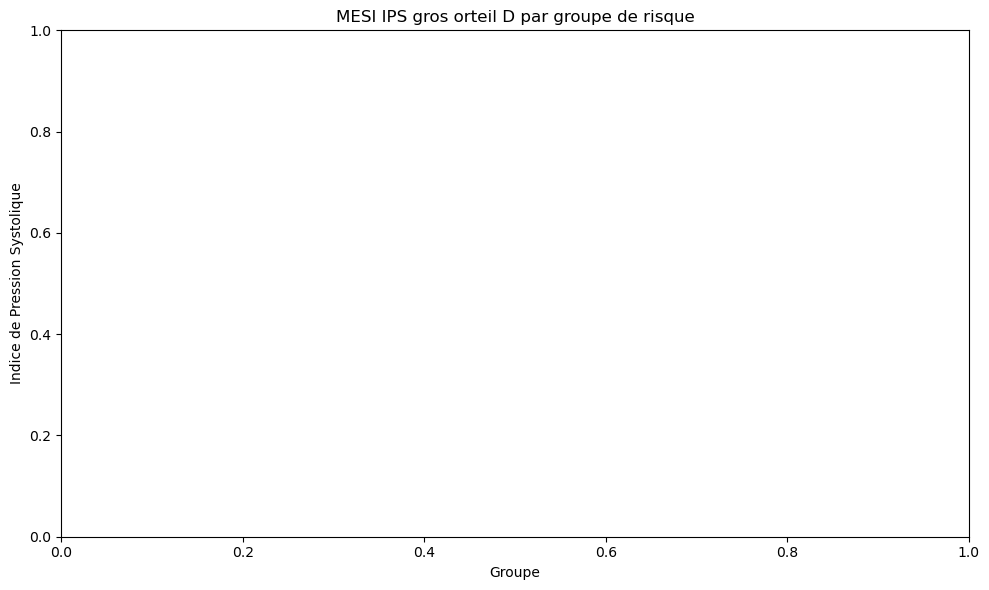


📈 Matrice de corrélation (MESI):

                             MESI Pression gros orteil D  \
MESI Pression gros orteil D                          NaN   
MESI Pression gros orteil G                          NaN   
MESI IPS gros orteil D                               NaN   
MESI IPS gros orteil G                               NaN   
Grade                                                NaN   

                             MESI Pression gros orteil G  \
MESI Pression gros orteil D                          NaN   
MESI Pression gros orteil G                          NaN   
MESI IPS gros orteil D                               NaN   
MESI IPS gros orteil G                               NaN   
Grade                                                NaN   

                             MESI IPS gros orteil D  MESI IPS gros orteil G  \
MESI Pression gros orteil D                     NaN                     NaN   
MESI Pression gros orteil G                     NaN                     NaN   
MESI I

/home/hamiri/.local/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/hamiri/.local/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


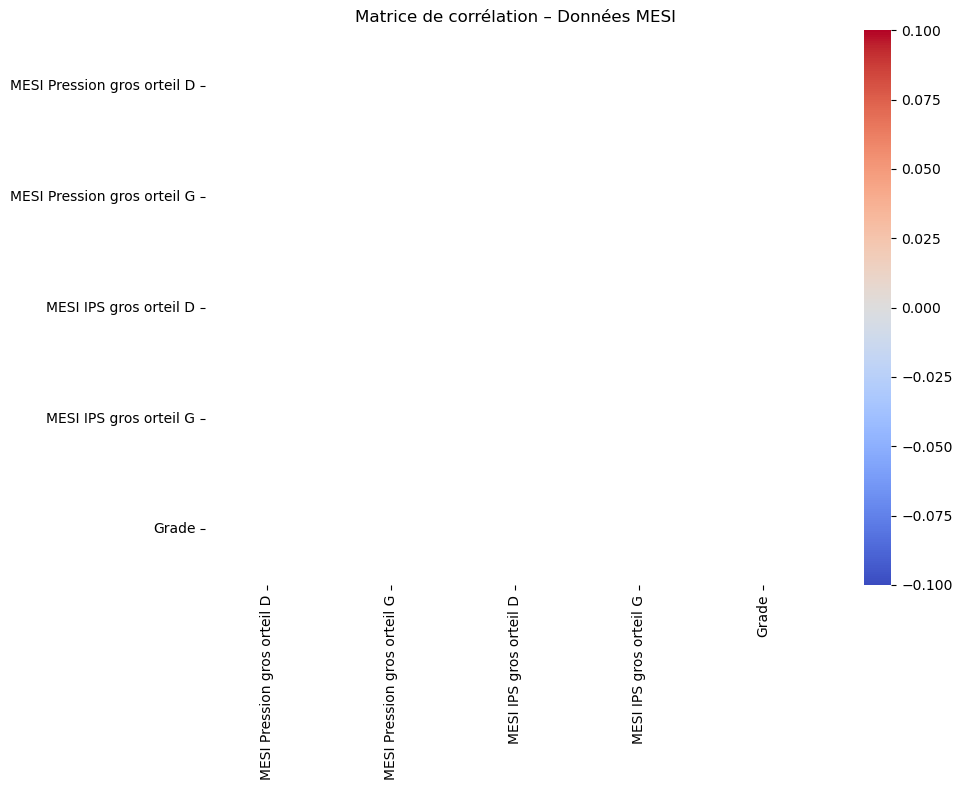

ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required by StandardScaler.

In [177]:
# --- 📥 Load MESI Toe Pressure & IPS data (rows 36 to 39) ---
mesi_data = df.iloc[36:40, 1:1+len(risk_values)]
mesi_data.index = [
    "MESI Pression gros orteil D",
    "MESI Pression gros orteil G",
    "MESI IPS gros orteil D",
    "MESI IPS gros orteil G"
]

# --- Transpose and clean ---
df_mesi = mesi_data.T
df_mesi = df_mesi.apply(pd.to_numeric, errors='coerce')
df_mesi = df_mesi.dropna()  # Supprimer les patients incomplets

# --- Add Grade and Group ---
df_mesi['Grade'] = risk_values.loc[df_mesi.index].values
df_mesi['Group'] = df_mesi['Grade'].apply(
    lambda x: 'A (Grades 0-1 😊👍)' if x in [0, 1] else 'B (Grades 2-3 ⚠️)'
)

# --- Group by A and B ---
group_a_mesi = df_mesi[df_mesi['Group'] == 'A (Grades 0-1 😊👍)']
group_b_mesi = df_mesi[df_mesi['Group'] == 'B (Grades 2-3 ⚠️)']

# --- 📊 T-tests ---
print("\n📊 T-test Results (MESI Data):\n")
for col in df_mesi.columns[:-2]:  # Skip 'Grade' and 'Group'
    a = group_a_mesi[col].dropna()
    b = group_b_mesi[col].dropna()
    if len(a) >= 2 and len(b) >= 2:
        t_stat, p_value = ttest_ind(a, b, equal_var=False)
        print(f"{col} → p-value = {p_value:.4f}")
    else:
        print(f"{col} → pas assez de données pour le test (nA={len(a)}, nB={len(b)})")

# --- 📦 Example Boxplot ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_mesi, x="Group", y="MESI IPS gros orteil D", palette="pastel")
plt.title("MESI IPS gros orteil D par groupe de risque")
plt.xlabel("Groupe")
plt.ylabel("Indice de Pression Systolique")
plt.tight_layout()
plt.show()

# --- 🔗 Correlation Matrix ---
print("\n📈 Matrice de corrélation (MESI):\n")
corr_mesi = df_mesi.drop(columns=['Group']).corr()
print(corr_mesi)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_mesi, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation – Données MESI")
plt.tight_layout()
plt.show()

# --- 🔁 Régression linéaire pour prédire le Grade ---
X_mesi = df_mesi.drop(columns=['Grade', 'Group'])
y_mesi = df_mesi['Grade']

scaler_mesi = StandardScaler()
X_mesi_scaled = scaler_mesi.fit_transform(X_mesi)

model_mesi = LinearRegression()
model_mesi.fit(X_mesi_scaled, y_mesi)

coeff_df_mesi = pd.DataFrame({
    "Feature": X_mesi.columns,
    "Coefficient": model_mesi.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("\n📉 Coefficients de la régression (MESI):")
print(coeff_df_mesi)

plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=coeff_df_mesi, palette="crest")
plt.title("Importance des variables (régression MESI)")
plt.tight_layout()
plt.show()


In [176]:
df_mesi = df_mesi.dropna()
print(f"✅ Patients restants après nettoyage : {df_mesi.shape[0]}")


✅ Patients restants après nettoyage : 0


### patient profiles close to the clinical transition threshold using unsupervised clustering (k-means, DBSCAN, etc.) :

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


df_all = pd.concat([df_thickness.drop(columns=['Grade', 'Group']),
                    df_mesi.drop(columns=['Grade', 'Group']),
                    df_roc.drop(columns=['Grade', 'Group'])],
                   axis=1, join='inner')

# Nettoyage
df_all = df_all.dropna()
df_all_scaled = StandardScaler().fit_transform(df_all)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_all_scaled)

df_all['Cluster'] = clusters

pca = PCA(n_components=2)
components = pca.fit_transform(df_all_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=df_all['Cluster'], palette='Set2')
plt.title("Clustering des patients (K-means + PCA)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


ValueError: Found array with 0 sample(s) (shape=(0, 20)) while a minimum of 1 is required by StandardScaler.